<h1><center><font color=D00000>Q-learning в средах OpenAI.gym</font></center></h1>

### <font color=black>Евгений Пономарев</font>
#### <font color=green>Сколковский институт науки и технологий</font>

Библиотеки:
* `pip install numpy`
* `pip install tensorflow`
* `pip install gym`
* `pip install gym[atari]`
* `pip install keras`
* `pip install matplotlib`

Документация к openai.gym:
* https://gym.openai.com/docs/

<h2><center><font color=D00000>Обучение с подкреплением aka Reinforcement learning:</font></center></h2>
 
В классической постановке предполагается **Марковский процесс принятия решений (Markov Decision Process)**:

Состоит из:
* Среды
* Агента
    
**MDP** задается через: 
* Множество состояний среды $\mathrm{S} : s_t \in \mathrm{S}$
* Доступные действия $\mathrm{A}: a_t \in \mathrm{A}$
* Модель среды (обычно неизвестна агенту): $s_{t+1} \sim \mathrm{P}_{env}(s_{t+1} | s_t, a_t)$
* Функция награды (обычно неизвестна агенту): $r_{t} \sim \mathrm{R}(r_{t} | a_t, s_t)$
  
Агент совершает действия в соответствии с выработанной политикой:
* $a_t \sim \pi(a_t|s_t)$

<font color=green>Цель агента - максимизировать ожидание кумулятивной награды:
$$R(\pi) = \mathbb{E}_{\pi, P, R} \sum_{t=start}^{end}{r_t} \to \max_{\pi}$$
    </font></center>

<img src="http://pp.userapi.com/c621707/v621707705/23555/2WlxiB6Di3o.jpg" alt="MDP" style="width: 600px;"/>

Основной плюс - можно не размечать данные


# Табличный Q-learning

Сопоставим каждой паре $(s,a)$ (состояние, действие) значение функции ценности действия - **$Q(s,a)$**
$$Q(s_t, a_t) = \mathbb{E}_{\pi, P, R} \sum_{i=0}^{N}{\gamma^ir_{t+i}}$$

Тогда награда за $$R(\pi) = \sum_{t=start}^{end}{r_t} \sim \sum_{t=start}^{end} Q(s_t|a_t)$$


Искомая $Q$ функция:
$$Q^*(s,a) = max_{\pi}Q^{\pi}(s,a)$$

Тогда жадная политика
$$ \pi(a|s) = \mathbb{[}a == \arg\max_a Q(s,a)\mathbb{]} $$
$$ a_t = \arg\max_a Q(s,a) $$
решает исходную задачу

Уравнение Беллмана для оптимальной функции:

$$Q^*(s,a) = \mathbb{E}_{P_{env}}(r_{t+1} + \gamma \max_{a'\in A} Q^*(s_{t+1},a')~~|~~s_t = s, a_t = a)$$




$$Q(s_{t}, a_t) = r_t + \gamma \cdot \max_{a' \in A}Q(s_{t+1}|a')$$



В простейшем случае, когда s~1,10,100; a~1,10 лучше просто выучить, что нужно делать, т.е. задать таблицу: 

| Q(s,a)| $s_1$ | $s_2$  | $s_3$ | ... |
|-----|-----|------|-----|-----|
| $a_1$ | 1   | 0    | 8   | ... |
| $a_2$ | 5   | 4    | 3   | ... |
| $a_3$ | 8   | -10 | 99  | ... |

Оценка $Q(s, a)$ экспоненциальным скользящим средним:


$$ Q(s, a) := Q(s, a) + \alpha \cdot [(r(a,s) + \max_{a'\ \in A} Q(s',a')) - Q(s,a)] $$

$$ Q(s,a) \to r(a,s) + \max Q(s')$$

<h2><center><font color=#D00000>CartPole</font></center></h2>

![cartpole](cartpole_gif.gif)
## Правила

### Вектор наблюдения

Num | Observation | Min | Max
---|---|---|---
0 | Позиция тележки | -2.4 | 2.4
1 | Скорость тележки | -Inf | Inf
2 | Угол наклона палки | ~ -41.8&deg; | ~ 41.8&deg;
3 | Угловая скорость палки | -Inf | Inf

### Действия

Num | Action
--- | ---
0 | Толкнуть влево
1 | Толкнуть вправо

Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

### Награда
1 за каждый шаг

### Начальное состояние
Случайные числа ±0.05

### Завершение эпизода
1. Наклон палки = ±20.9°
2. Положение тележки = ±2.4 (центр тележки за пределами экрана)
3. Eлительность эпизода 200 (v.0) или 500 (v.1)

### Условия победы
Продержаться 100 последовательных эпизодов со средним результатом более 195 (v.0) или 475 (v.1)

In [1]:
import gym
import numpy as np
import random
import pandas
import matplotlib.pyplot as plt


In [2]:
class QLearn:
    def __init__(self, actions, epsilon, alpha, gamma):
        self.q = {}
        self.epsilon = epsilon  # exploration constant
        self.alpha = alpha      # discount constant
        self.gamma = gamma      # discount factor
        self.actions = actions

    def chooseAction(self, state, return_q=False):
        q = [self.q.get((state, a), 0.) for a in self.actions]
        maxQ = max(q)
        
        # Отвечает за баланс исследование-использование (exploration vs expluatation)
        # С вероятностью epsilon случайное действие, 1-epsilon - argmax(Q)
        if random.random() < self.epsilon:
            minQ = min(q); mag = max(abs(minQ), abs(maxQ))
            # add random values to all the actions, recalculate maxQ
            q = [q[i] + random.random() * mag - .5 * mag for i in range(len(self.actions))]
            maxQ = max(q)

        count = q.count(maxQ)
        # Если максимум Q достигается для двух и более действий - берем любое
        if count > 1:
            best = [i for i in range(len(self.actions)) if q[i] == maxQ]
            i = random.choice(best)
        else:
            i = q.index(maxQ)
        
        action = self.actions[i]
        if return_q: # if they want it, give it!
            return action, q
        return action
    
    def learn(self, state1, action1, reward, state2):
        maxqnew = max([self.q.get((state, action), 0.) for a in self.actions])
        new_q = reward + self.gamma*maxqnew

        old_q = self.q.get((state, action), None)
        if old_q is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = old_q + self.alpha * (new_q - old_q)

def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]

In [3]:
env = gym.make('CartPole-v0')
goal_average_steps = 195
max_number_of_steps = 200
# Для создания видео и отправки данных на сайт gym.openai.com
env = gym.wrappers.Monitor(env, '/tmp/cartpole-experiment-1', force=True)

n_bins = 8
n_bins_angle = 10

# Дискретизуем непрерывное пространство состояний в n_bins^2*n_bins_angle^2
cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

# Инициализация табличного Q-learning
alpha = 0.5
gamma = 0.9
epsilon = 0.1
qlearn = QLearn(actions=range(env.action_space.n),
                alpha=alpha, gamma=gamma, epsilon=epsilon)

[2017-10-05 17:54:33,024] Making new env: CartPole-v0
[2017-10-05 17:54:33,027] Clearing 70 monitor files from previous run (because force=True was provided)


```C
init s
init Q
eps = 0.1
alpha = 0.5
    
for episode = 1,M do:
    с вероятностью eps:
        a = ramdom(A)
    else:
        a = argmax(Q[s,a])
    
    Совершить действие a;
    Получить награду r;
    Получить новое состояние s_new;
    
    Улучшить стратегию:
        Q[s,a] := Q[s,a] + alpha*((r + max(Q[s_new,:])) - Q[s,a])
    
    s := s_new
```

In [4]:

last_reward = np.ndarray(0)
for i_episode in xrange(30000):
    
    # получим наблюдение
    observation = env.reset()
    # дискретизуем и создадим состояние
    cart_position, pole_angle, cart_velocity, angle_rate_of_change = observation
    state = build_state([to_bin(cart_position, cart_position_bins),
                     to_bin(pole_angle, pole_angle_bins),
                     to_bin(cart_velocity, cart_velocity_bins),
                     to_bin(angle_rate_of_change, angle_rate_bins)])
    cum_reward = 0
    for t in xrange(max_number_of_steps):
        # можно смотреть, как агент учится
#         if i_episode % 300 == 0: 
#             env.render()
        
        # в соответствии с политикой выберем действие
        action = qlearn.chooseAction(state)
        # получим новое наблюдение, награду, метку конца эпизода
        observation, reward, is_done, _ = env.step(action)
        cum_reward += reward
        # дискретизуем и создадим состояние
        cart_position, pole_angle, cart_velocity, angle_rate_of_change = observation
        new_state = build_state([to_bin(cart_position, cart_position_bins),
                         to_bin(pole_angle, pole_angle_bins),
                         to_bin(cart_velocity, cart_velocity_bins),
                         to_bin(angle_rate_of_change, angle_rate_bins)])


        if not(is_done):
            qlearn.learn(state, action, reward, new_state)
            state = new_state
        else:
            # штраф за проигрыш
            reward = -200
            qlearn.learn(state, action, reward, new_state)
            last_reward = np.append(last_reward, cum_reward)
            break
    print("episode: {}, score: {}, 30-mean: {:0.1f}".format(i_episode, t, last_reward[-30:].mean()))
    if (last_reward[-100:].mean() > goal_average_steps):
        print ("Win!")
        break
env.close()
# gym.upload('/tmp/cartpole-experiment-1', algorithm_id='simple Q-learning', api_key='your-key')

[2017-10-05 17:54:35,128] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video000000.mp4
[2017-10-05 17:54:35,759] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video000001.mp4


episode: 0, score: 23, 30-mean: 24.0


[2017-10-05 17:54:36,500] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video000008.mp4
[2017-10-05 17:54:36,661] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video000027.mp4


episode: 1, score: 41, 30-mean: 33.0
episode: 2, score: 36, 30-mean: 34.3
episode: 3, score: 70, 30-mean: 43.5
episode: 4, score: 8, 30-mean: 36.6
episode: 5, score: 13, 30-mean: 32.8
episode: 6, score: 9, 30-mean: 29.6
episode: 7, score: 51, 30-mean: 32.4
episode: 8, score: 8, 30-mean: 29.8
episode: 9, score: 9, 30-mean: 27.8
episode: 10, score: 18, 30-mean: 27.0
episode: 11, score: 28, 30-mean: 27.2
episode: 12, score: 10, 30-mean: 25.9
episode: 13, score: 14, 30-mean: 25.1
episode: 14, score: 10, 30-mean: 24.2
episode: 15, score: 21, 30-mean: 24.1
episode: 16, score: 20, 30-mean: 23.9
episode: 17, score: 12, 30-mean: 23.3
episode: 18, score: 33, 30-mean: 23.8
episode: 19, score: 23, 30-mean: 23.9
episode: 20, score: 10, 30-mean: 23.2
episode: 21, score: 43, 30-mean: 24.2
episode: 22, score: 11, 30-mean: 23.7
episode: 23, score: 52, 30-mean: 24.9
episode: 24, score: 49, 30-mean: 25.9
episode: 25, score: 19, 30-mean: 25.7
episode: 26, score: 40, 30-mean: 26.2


[2017-10-05 17:54:36,974] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video000064.mp4


episode: 27, score: 15, 30-mean: 25.9
episode: 28, score: 8, 30-mean: 25.3
episode: 29, score: 8, 30-mean: 24.7
episode: 30, score: 13, 30-mean: 24.4
episode: 31, score: 13, 30-mean: 23.5
episode: 32, score: 13, 30-mean: 22.7
episode: 33, score: 11, 30-mean: 20.7
episode: 34, score: 73, 30-mean: 22.9
episode: 35, score: 57, 30-mean: 24.4
episode: 36, score: 48, 30-mean: 25.7
episode: 37, score: 8, 30-mean: 24.2
episode: 38, score: 84, 30-mean: 26.8
episode: 39, score: 14, 30-mean: 26.9
episode: 40, score: 51, 30-mean: 28.0
episode: 41, score: 43, 30-mean: 28.5
episode: 42, score: 14, 30-mean: 28.7
episode: 43, score: 10, 30-mean: 28.5
episode: 44, score: 18, 30-mean: 28.8
episode: 45, score: 23, 30-mean: 28.9
episode: 46, score: 11, 30-mean: 28.6
episode: 47, score: 33, 30-mean: 29.3
episode: 48, score: 13, 30-mean: 28.6
episode: 49, score: 15, 30-mean: 28.3
episode: 50, score: 9, 30-mean: 28.3
episode: 51, score: 10, 30-mean: 27.2
episode: 52, score: 12, 30-mean: 27.2
episode: 53, sco

[2017-10-05 17:54:37,182] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video000125.mp4



episode: 65, score: 7, 30-mean: 25.4
episode: 66, score: 21, 30-mean: 24.5
episode: 67, score: 65, 30-mean: 26.4
episode: 68, score: 8, 30-mean: 23.9
episode: 69, score: 61, 30-mean: 25.4
episode: 70, score: 41, 30-mean: 25.1
episode: 71, score: 14, 30-mean: 24.1
episode: 72, score: 10, 30-mean: 24.0
episode: 73, score: 13, 30-mean: 24.1
episode: 74, score: 59, 30-mean: 25.5
episode: 75, score: 55, 30-mean: 26.5
episode: 76, score: 44, 30-mean: 27.6
episode: 77, score: 76, 30-mean: 29.1
episode: 78, score: 18, 30-mean: 29.2
episode: 79, score: 12, 30-mean: 29.1
episode: 80, score: 9, 30-mean: 29.1
episode: 81, score: 44, 30-mean: 30.3
episode: 82, score: 18, 30-mean: 30.5
episode: 83, score: 11, 30-mean: 30.5
episode: 84, score: 8, 30-mean: 30.0
episode: 85, score: 12, 30-mean: 29.2
episode: 86, score: 69, 30-mean: 30.3
episode: 87, score: 10, 30-mean: 30.3
episode: 88, score: 57, 30-mean: 31.8
episode: 89, score: 10, 30-mean: 31.8
episode: 90, score: 32, 30-mean: 32.6
episode: 91, sc

[2017-10-05 17:54:37,968] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video000216.mp4


episode: 125, score: 38, 30-mean: 25.0
episode: 126, score: 16, 30-mean: 25.2
episode: 127, score: 37, 30-mean: 25.3
episode: 128, score: 44, 30-mean: 24.6
episode: 129, score: 8, 30-mean: 23.3
episode: 130, score: 8, 30-mean: 23.2
episode: 131, score: 10, 30-mean: 23.2
episode: 132, score: 47, 30-mean: 24.5
episode: 133, score: 18, 30-mean: 24.8
episode: 134, score: 51, 30-mean: 26.1
episode: 135, score: 34, 30-mean: 24.4
episode: 136, score: 64, 30-mean: 26.3
episode: 137, score: 26, 30-mean: 26.9
episode: 138, score: 90, 30-mean: 29.7
episode: 139, score: 34, 30-mean: 30.2
episode: 140, score: 10, 30-mean: 30.2
episode: 141, score: 44, 30-mean: 31.3
episode: 142, score: 55, 30-mean: 32.7
episode: 143, score: 46, 30-mean: 33.9
episode: 144, score: 35, 30-mean: 32.9
episode: 145, score: 18, 30-mean: 32.3
episode: 146, score: 12, 30-mean: 32.4
episode: 147, score: 66, 30-mean: 32.4
episode: 148, score: 19, 30-mean: 32.7
episode: 149, score: 10, 30-mean: 32.7
episode: 150, score: 10, 30

[2017-10-05 17:54:38,406] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video000343.mp4


episode: 216, score: 17, 30-mean: 24.3
episode: 217, score: 12, 30-mean: 24.4
episode: 218, score: 25, 30-mean: 22.8
episode: 219, score: 11, 30-mean: 22.9
episode: 220, score: 8, 30-mean: 22.8
episode: 221, score: 23, 30-mean: 22.9
episode: 222, score: 8, 30-mean: 22.9
episode: 223, score: 29, 30-mean: 22.7
episode: 224, score: 19, 30-mean: 23.0
episode: 225, score: 23, 30-mean: 23.5
episode: 226, score: 8, 30-mean: 23.1
episode: 227, score: 70, 30-mean: 24.5
episode: 228, score: 10, 30-mean: 23.4
episode: 229, score: 65, 30-mean: 25.2
episode: 230, score: 12, 30-mean: 23.8
episode: 231, score: 23, 30-mean: 24.3
episode: 232, score: 40, 30-mean: 25.0
episode: 233, score: 8, 30-mean: 24.8
episode: 234, score: 28, 30-mean: 25.4
episode: 235, score: 72, 30-mean: 27.4
episode: 236, score: 8, 30-mean: 27.3
episode: 237, score: 8, 30-mean: 26.0
episode: 238, score: 10, 30-mean: 23.3
episode: 239, score: 55, 30-mean: 23.7
episode: 240, score: 8, 30-mean: 23.7
episode: 241, score: 38, 30-mean

[2017-10-05 17:54:39,297] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video000512.mp4


episode: 343, score: 42, 30-mean: 32.7
episode: 344, score: 10, 30-mean: 32.2
episode: 345, score: 9, 30-mean: 32.2
episode: 346, score: 12, 30-mean: 32.2
episode: 347, score: 8, 30-mean: 30.0
episode: 348, score: 16, 30-mean: 29.8
episode: 349, score: 11, 30-mean: 28.8
episode: 350, score: 38, 30-mean: 28.1
episode: 351, score: 8, 30-mean: 27.8
episode: 352, score: 44, 30-mean: 26.9
episode: 353, score: 41, 30-mean: 26.8
episode: 354, score: 8, 30-mean: 26.5
episode: 355, score: 51, 30-mean: 26.9
episode: 356, score: 29, 30-mean: 27.1
episode: 357, score: 68, 30-mean: 27.3
episode: 358, score: 31, 30-mean: 28.1
episode: 359, score: 8, 30-mean: 28.0
episode: 360, score: 8, 30-mean: 27.0
episode: 361, score: 13, 30-mean: 26.0
episode: 362, score: 25, 30-mean: 26.5
episode: 363, score: 34, 30-mean: 26.4
episode: 364, score: 12, 30-mean: 25.7
episode: 365, score: 12, 30-mean: 25.5
episode: 366, score: 10, 30-mean: 24.2
episode: 367, score: 12, 30-mean: 24.3
episode: 368, score: 32, 30-mea

[2017-10-05 17:54:39,949] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video000729.mp4


episode: 663, score: 26, 30-mean: 61.8
episode: 664, score: 11, 30-mean: 59.6
episode: 665, score: 97, 30-mean: 61.2
episode: 666, score: 191, 30-mean: 66.8
episode: 667, score: 43, 30-mean: 66.2
episode: 668, score: 157, 30-mean: 66.8
episode: 669, score: 35, 30-mean: 67.3
episode: 670, score: 27, 30-mean: 66.5
episode: 671, score: 13, 30-mean: 61.3
episode: 672, score: 28, 30-mean: 61.3
episode: 673, score: 9, 30-mean: 60.8
episode: 674, score: 122, 30-mean: 64.6
episode: 675, score: 29, 30-mean: 65.2
episode: 676, score: 12, 30-mean: 65.2
episode: 677, score: 11, 30-mean: 63.3
episode: 678, score: 19, 30-mean: 60.1
episode: 679, score: 38, 30-mean: 55.3
episode: 680, score: 23, 30-mean: 55.3
episode: 681, score: 17, 30-mean: 49.2
episode: 682, score: 199, 30-mean: 52.3
episode: 683, score: 101, 30-mean: 54.6
episode: 684, score: 11, 30-mean: 50.1
episode: 685, score: 12, 30-mean: 50.2
episode: 686, score: 113, 30-mean: 52.0
episode: 687, score: 10, 30-mean: 51.8
episode: 688, score:

[2017-10-05 17:54:42,594] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video001000.mp4


episode: 827, score: 67, 30-mean: 34.4
episode: 828, score: 21, 30-mean: 34.8
episode: 829, score: 15, 30-mean: 33.7
episode: 830, score: 21, 30-mean: 32.5
episode: 831, score: 20, 30-mean: 29.9
episode: 832, score: 20, 30-mean: 29.7
episode: 833, score: 38, 30-mean: 29.5
episode: 834, score: 43, 30-mean: 30.3
episode: 835, score: 17, 30-mean: 30.4
episode: 836, score: 20, 30-mean: 28.7
episode: 837, score: 63, 30-mean: 30.1
episode: 838, score: 15, 30-mean: 28.7
episode: 839, score: 19, 30-mean: 28.2
episode: 840, score: 50, 30-mean: 28.8
episode: 841, score: 30, 30-mean: 29.5
episode: 842, score: 18, 30-mean: 29.4
episode: 843, score: 20, 30-mean: 29.6
episode: 844, score: 18, 30-mean: 29.8
episode: 845, score: 19, 30-mean: 29.1
episode: 846, score: 97, 30-mean: 30.7
episode: 847, score: 51, 30-mean: 28.9
episode: 848, score: 17, 30-mean: 28.9
episode: 849, score: 50, 30-mean: 30.3
episode: 850, score: 63, 30-mean: 31.6
episode: 851, score: 20, 30-mean: 31.5
episode: 852, score: 37, 

episode: 1127, score: 51, 30-mean: 63.4
episode: 1128, score: 37, 30-mean: 63.9
episode: 1129, score: 30, 30-mean: 64.4
episode: 1130, score: 41, 30-mean: 65.5
episode: 1131, score: 157, 30-mean: 65.6
episode: 1132, score: 80, 30-mean: 66.7
episode: 1133, score: 199, 30-mean: 73.1
episode: 1134, score: 70, 30-mean: 74.7
episode: 1135, score: 54, 30-mean: 70.1
episode: 1136, score: 17, 30-mean: 70.1
episode: 1137, score: 54, 30-mean: 68.5
episode: 1138, score: 23, 30-mean: 66.5
episode: 1139, score: 9, 30-mean: 66.1
episode: 1140, score: 11, 30-mean: 63.4
episode: 1141, score: 8, 30-mean: 61.0
episode: 1142, score: 199, 30-mean: 64.7
episode: 1143, score: 74, 30-mean: 63.4
episode: 1144, score: 55, 30-mean: 62.5
episode: 1145, score: 60, 30-mean: 64.1
episode: 1146, score: 188, 30-mean: 69.9
episode: 1147, score: 23, 30-mean: 69.3
episode: 1148, score: 9, 30-mean: 66.1
episode: 1149, score: 25, 30-mean: 65.8
episode: 1150, score: 61, 30-mean: 64.8
episode: 1151, score: 15, 30-mean: 63.7

episode: 1390, score: 116, 30-mean: 58.1
episode: 1391, score: 18, 30-mean: 57.0
episode: 1392, score: 19, 30-mean: 56.4
episode: 1393, score: 35, 30-mean: 54.8
episode: 1394, score: 15, 30-mean: 53.8
episode: 1395, score: 169, 30-mean: 59.2
episode: 1396, score: 132, 30-mean: 62.5
episode: 1397, score: 28, 30-mean: 62.8
episode: 1398, score: 14, 30-mean: 63.0
episode: 1399, score: 38, 30-mean: 63.4
episode: 1400, score: 20, 30-mean: 63.1
episode: 1401, score: 17, 30-mean: 63.1
episode: 1402, score: 67, 30-mean: 64.9
episode: 1403, score: 104, 30-mean: 66.7
episode: 1404, score: 30, 30-mean: 65.3
episode: 1405, score: 104, 30-mean: 66.9
episode: 1406, score: 82, 30-mean: 69.4
episode: 1407, score: 68, 30-mean: 69.3
episode: 1408, score: 44, 30-mean: 67.2
episode: 1409, score: 14, 30-mean: 64.0
episode: 1410, score: 101, 30-mean: 64.3
episode: 1411, score: 9, 30-mean: 63.8
episode: 1412, score: 199, 30-mean: 68.6
episode: 1413, score: 37, 30-mean: 68.1
episode: 1414, score: 23, 30-mean:

episode: 1638, score: 192, 30-mean: 86.9
episode: 1639, score: 39, 30-mean: 87.7
episode: 1640, score: 52, 30-mean: 86.0
episode: 1641, score: 22, 30-mean: 82.7
episode: 1642, score: 199, 30-mean: 88.3
episode: 1643, score: 52, 30-mean: 85.1
episode: 1644, score: 30, 30-mean: 84.2
episode: 1645, score: 24, 30-mean: 83.1
episode: 1646, score: 11, 30-mean: 82.9
episode: 1647, score: 24, 30-mean: 83.3
episode: 1648, score: 115, 30-mean: 80.5
episode: 1649, score: 71, 30-mean: 81.5
episode: 1650, score: 40, 30-mean: 78.2
episode: 1651, score: 81, 30-mean: 78.8
episode: 1652, score: 89, 30-mean: 77.8
episode: 1653, score: 47, 30-mean: 78.6
episode: 1654, score: 17, 30-mean: 78.0
episode: 1655, score: 70, 30-mean: 79.7
episode: 1656, score: 8, 30-mean: 76.2
episode: 1657, score: 183, 30-mean: 79.0
episode: 1658, score: 58, 30-mean: 75.9
episode: 1659, score: 18, 30-mean: 72.4
episode: 1660, score: 17, 30-mean: 67.8
episode: 1661, score: 9, 30-mean: 65.5
episode: 1662, score: 82, 30-mean: 67.

[2017-10-05 17:54:45,109] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video002000.mp4


episode: 1873, score: 169, 30-mean: 63.1
episode: 1874, score: 108, 30-mean: 64.0
episode: 1875, score: 14, 30-mean: 64.2
episode: 1876, score: 87, 30-mean: 65.2
episode: 1877, score: 96, 30-mean: 66.3
episode: 1878, score: 93, 30-mean: 68.7
episode: 1879, score: 110, 30-mean: 71.5
episode: 1880, score: 108, 30-mean: 72.7
episode: 1881, score: 9, 30-mean: 69.7
episode: 1882, score: 31, 30-mean: 68.0
episode: 1883, score: 54, 30-mean: 63.2
episode: 1884, score: 76, 30-mean: 64.2
episode: 1885, score: 118, 30-mean: 64.9
episode: 1886, score: 69, 30-mean: 66.5
episode: 1887, score: 28, 30-mean: 66.7
episode: 1888, score: 143, 30-mean: 71.0
episode: 1889, score: 25, 30-mean: 69.3
episode: 1890, score: 30, 30-mean: 69.7
episode: 1891, score: 37, 30-mean: 70.1
episode: 1892, score: 30, 30-mean: 70.1
episode: 1893, score: 69, 30-mean: 67.8
episode: 1894, score: 44, 30-mean: 67.1
episode: 1895, score: 9, 30-mean: 66.5
episode: 1896, score: 27, 30-mean: 60.8
episode: 1897, score: 31, 30-mean: 6

episode: 2094, score: 140, 30-mean: 73.7
episode: 2095, score: 155, 30-mean: 74.9
episode: 2096, score: 125, 30-mean: 78.1
episode: 2097, score: 38, 30-mean: 76.3
episode: 2098, score: 133, 30-mean: 79.8
episode: 2099, score: 199, 30-mean: 82.3
episode: 2100, score: 134, 30-mean: 85.8
episode: 2101, score: 58, 30-mean: 87.0
episode: 2102, score: 54, 30-mean: 87.2
episode: 2103, score: 138, 30-mean: 90.9
episode: 2104, score: 63, 30-mean: 88.3
episode: 2105, score: 199, 30-mean: 94.6
episode: 2106, score: 179, 30-mean: 99.5
episode: 2107, score: 97, 30-mean: 98.3
episode: 2108, score: 23, 30-mean: 98.1
episode: 2109, score: 35, 30-mean: 96.4
episode: 2110, score: 199, 30-mean: 102.0
episode: 2111, score: 34, 30-mean: 98.8
episode: 2112, score: 55, 30-mean: 100.0
episode: 2113, score: 199, 30-mean: 106.2
episode: 2114, score: 83, 30-mean: 103.2
episode: 2115, score: 199, 30-mean: 103.6
episode: 2116, score: 45, 30-mean: 103.3
episode: 2117, score: 55, 30-mean: 100.5
episode: 2118, score:

episode: 2429, score: 51, 30-mean: 43.1
episode: 2430, score: 45, 30-mean: 43.9
episode: 2431, score: 43, 30-mean: 44.6
episode: 2432, score: 55, 30-mean: 43.9
episode: 2433, score: 22, 30-mean: 43.0
episode: 2434, score: 99, 30-mean: 45.5
episode: 2435, score: 58, 30-mean: 45.9
episode: 2436, score: 23, 30-mean: 46.1
episode: 2437, score: 27, 30-mean: 43.9
episode: 2438, score: 81, 30-mean: 43.0
episode: 2439, score: 35, 30-mean: 41.9
episode: 2440, score: 21, 30-mean: 42.1
episode: 2441, score: 23, 30-mean: 41.4
episode: 2442, score: 52, 30-mean: 40.7
episode: 2443, score: 52, 30-mean: 42.1
episode: 2444, score: 22, 30-mean: 42.3
episode: 2445, score: 47, 30-mean: 43.5
episode: 2446, score: 37, 30-mean: 43.6
episode: 2447, score: 21, 30-mean: 42.5
episode: 2448, score: 144, 30-mean: 46.5
episode: 2449, score: 19, 30-mean: 46.5
episode: 2450, score: 38, 30-mean: 47.1
episode: 2451, score: 22, 30-mean: 47.1
episode: 2452, score: 10, 30-mean: 46.3
episode: 2453, score: 72, 30-mean: 47.0

[2017-10-05 17:54:49,591] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video003000.mp4



episode: 2882, score: 21, 30-mean: 18.4
episode: 2883, score: 25, 30-mean: 18.0
episode: 2884, score: 20, 30-mean: 18.3
episode: 2885, score: 14, 30-mean: 18.5
episode: 2886, score: 20, 30-mean: 18.8
episode: 2887, score: 16, 30-mean: 19.1
episode: 2888, score: 33, 30-mean: 18.5
episode: 2889, score: 45, 30-mean: 19.2
episode: 2890, score: 16, 30-mean: 19.5
episode: 2891, score: 10, 30-mean: 19.3
episode: 2892, score: 20, 30-mean: 19.3
episode: 2893, score: 29, 30-mean: 19.8
episode: 2894, score: 17, 30-mean: 19.9
episode: 2895, score: 17, 30-mean: 20.2
episode: 2896, score: 23, 30-mean: 20.6
episode: 2897, score: 40, 30-mean: 21.6
episode: 2898, score: 17, 30-mean: 21.9
episode: 2899, score: 22, 30-mean: 22.0
episode: 2900, score: 32, 30-mean: 22.7
episode: 2901, score: 10, 30-mean: 22.4
episode: 2902, score: 10, 30-mean: 22.4
episode: 2903, score: 22, 30-mean: 22.5
episode: 2904, score: 11, 30-mean: 22.4
episode: 2905, score: 16, 30-mean: 22.2
episode: 2906, score: 10, 30-mean: 21.3

episode: 3298, score: 14, 30-mean: 17.4
episode: 3299, score: 13, 30-mean: 17.6
episode: 3300, score: 18, 30-mean: 17.4
episode: 3301, score: 23, 30-mean: 17.6
episode: 3302, score: 16, 30-mean: 17.4
episode: 3303, score: 19, 30-mean: 17.7
episode: 3304, score: 10, 30-mean: 17.3
episode: 3305, score: 21, 30-mean: 16.8
episode: 3306, score: 9, 30-mean: 16.4
episode: 3307, score: 8, 30-mean: 16.3
episode: 3308, score: 16, 30-mean: 16.1
episode: 3309, score: 35, 30-mean: 16.8
episode: 3310, score: 28, 30-mean: 17.2
episode: 3311, score: 20, 30-mean: 17.5
episode: 3312, score: 9, 30-mean: 17.5
episode: 3313, score: 10, 30-mean: 17.1
episode: 3314, score: 17, 30-mean: 17.4
episode: 3315, score: 12, 30-mean: 17.1
episode: 3316, score: 19, 30-mean: 17.4
episode: 3317, score: 9, 30-mean: 16.9
episode: 3318, score: 13, 30-mean: 17.0
episode: 3319, score: 19, 30-mean: 17.4
episode: 3320, score: 15, 30-mean: 17.1
episode: 3321, score: 17, 30-mean: 16.6
episode: 3322, score: 22, 30-mean: 17.1
epis

episode: 3608, score: 14, 30-mean: 16.9
episode: 3609, score: 10, 30-mean: 16.9
episode: 3610, score: 18, 30-mean: 15.8
episode: 3611, score: 12, 30-mean: 15.6
episode: 3612, score: 19, 30-mean: 15.5
episode: 3613, score: 23, 30-mean: 16.0
episode: 3614, score: 14, 30-mean: 15.7
episode: 3615, score: 27, 30-mean: 16.3
episode: 3616, score: 8, 30-mean: 16.3
episode: 3617, score: 22, 30-mean: 16.7
episode: 3618, score: 16, 30-mean: 16.9
episode: 3619, score: 21, 30-mean: 17.1
episode: 3620, score: 15, 30-mean: 17.2
episode: 3621, score: 9, 30-mean: 17.2
episode: 3622, score: 25, 30-mean: 17.3
episode: 3623, score: 7, 30-mean: 17.3
episode: 3624, score: 12, 30-mean: 17.1
episode: 3625, score: 14, 30-mean: 17.2
episode: 3626, score: 22, 30-mean: 17.5
episode: 3627, score: 49, 30-mean: 18.8
episode: 3628, score: 22, 30-mean: 19.0
episode: 3629, score: 21, 30-mean: 19.1
episode: 3630, score: 19, 30-mean: 18.9
episode: 3631, score: 23, 30-mean: 19.1
episode: 3632, score: 15, 30-mean: 19.0
epi

[2017-10-05 17:54:50,971] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video004000.mp4


episode: 3980, score: 22, 30-mean: 16.2
episode: 3981, score: 19, 30-mean: 16.6
episode: 3982, score: 23, 30-mean: 17.1
episode: 3983, score: 10, 30-mean: 17.1
episode: 3984, score: 21, 30-mean: 17.3
episode: 3985, score: 12, 30-mean: 17.2
episode: 3986, score: 9, 30-mean: 17.2
episode: 3987, score: 27, 30-mean: 17.6
episode: 3988, score: 22, 30-mean: 18.0
episode: 3989, score: 23, 30-mean: 18.5
episode: 3990, score: 20, 30-mean: 18.4
episode: 3991, score: 9, 30-mean: 18.3
episode: 3992, score: 19, 30-mean: 18.4
episode: 3993, score: 23, 30-mean: 18.7
episode: 3994, score: 22, 30-mean: 18.8
episode: 3995, score: 9, 30-mean: 18.8
episode: 3996, score: 18, 30-mean: 18.8
episode: 3997, score: 9, 30-mean: 18.5
episode: 3998, score: 23, 30-mean: 18.9
episode: 3999, score: 19, 30-mean: 18.6
episode: 4000, score: 18, 30-mean: 18.8
episode: 4001, score: 23, 30-mean: 19.1
episode: 4002, score: 10, 30-mean: 18.8
episode: 4003, score: 39, 30-mean: 19.6
episode: 4004, score: 17, 30-mean: 19.6
epis

episode: 4272, score: 21, 30-mean: 26.9
episode: 4273, score: 10, 30-mean: 25.7
episode: 4274, score: 68, 30-mean: 27.5
episode: 4275, score: 43, 30-mean: 26.2
episode: 4276, score: 19, 30-mean: 26.5
episode: 4277, score: 33, 30-mean: 27.3
episode: 4278, score: 20, 30-mean: 27.2
episode: 4279, score: 62, 30-mean: 29.0
episode: 4280, score: 31, 30-mean: 29.4
episode: 4281, score: 8, 30-mean: 28.7
episode: 4282, score: 9, 30-mean: 28.7
episode: 4283, score: 25, 30-mean: 28.9
episode: 4284, score: 53, 30-mean: 29.9
episode: 4285, score: 47, 30-mean: 29.7
episode: 4286, score: 13, 30-mean: 28.2
episode: 4287, score: 16, 30-mean: 28.3
episode: 4288, score: 18, 30-mean: 28.1
episode: 4289, score: 19, 30-mean: 28.0
episode: 4290, score: 107, 30-mean: 30.9
episode: 4291, score: 19, 30-mean: 30.6
episode: 4292, score: 22, 30-mean: 29.7
episode: 4293, score: 9, 30-mean: 29.4
episode: 4294, score: 36, 30-mean: 30.1
episode: 4295, score: 33, 30-mean: 29.4
episode: 4296, score: 17, 30-mean: 29.5
ep

episode: 4550, score: 32, 30-mean: 21.9
episode: 4551, score: 22, 30-mean: 22.2
episode: 4552, score: 51, 30-mean: 23.4
episode: 4553, score: 27, 30-mean: 23.8
episode: 4554, score: 16, 30-mean: 24.0
episode: 4555, score: 9, 30-mean: 24.1
episode: 4556, score: 12, 30-mean: 23.8
episode: 4557, score: 16, 30-mean: 23.9
episode: 4558, score: 98, 30-mean: 26.0
episode: 4559, score: 35, 30-mean: 26.7
episode: 4560, score: 22, 30-mean: 27.0
episode: 4561, score: 39, 30-mean: 27.3
episode: 4562, score: 27, 30-mean: 27.8
episode: 4563, score: 10, 30-mean: 27.5
episode: 4564, score: 23, 30-mean: 27.7
episode: 4565, score: 18, 30-mean: 26.1
episode: 4566, score: 9, 30-mean: 26.0
episode: 4567, score: 14, 30-mean: 24.4
episode: 4568, score: 7, 30-mean: 24.0
episode: 4569, score: 9, 30-mean: 24.0
episode: 4570, score: 10, 30-mean: 23.6
episode: 4571, score: 16, 30-mean: 23.7
episode: 4572, score: 7, 30-mean: 23.6
episode: 4573, score: 12, 30-mean: 23.4
episode: 4574, score: 10, 30-mean: 23.4
episo

[2017-10-05 17:54:52,021] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video005000.mp4


episode: 4843, score: 24, 30-mean: 23.4
episode: 4844, score: 10, 30-mean: 21.9
episode: 4845, score: 26, 30-mean: 22.5
episode: 4846, score: 22, 30-mean: 22.8
episode: 4847, score: 12, 30-mean: 22.8
episode: 4848, score: 99, 30-mean: 24.8
episode: 4849, score: 33, 30-mean: 25.6
episode: 4850, score: 9, 30-mean: 24.9
episode: 4851, score: 16, 30-mean: 24.9
episode: 4852, score: 84, 30-mean: 26.9
episode: 4853, score: 12, 30-mean: 26.3
episode: 4854, score: 8, 30-mean: 25.9
episode: 4855, score: 21, 30-mean: 26.1
episode: 4856, score: 17, 30-mean: 25.5
episode: 4857, score: 19, 30-mean: 25.8
episode: 4858, score: 25, 30-mean: 25.9
episode: 4859, score: 18, 30-mean: 25.9
episode: 4860, score: 26, 30-mean: 26.5
episode: 4861, score: 10, 30-mean: 26.0
episode: 4862, score: 22, 30-mean: 25.6
episode: 4863, score: 10, 30-mean: 24.8
episode: 4864, score: 34, 30-mean: 25.6
episode: 4865, score: 16, 30-mean: 25.5
episode: 4866, score: 73, 30-mean: 27.6
episode: 4867, score: 9, 30-mean: 27.2
epi

episode: 5226, score: 8, 30-mean: 26.0
episode: 5227, score: 19, 30-mean: 26.3
episode: 5228, score: 20, 30-mean: 24.9
episode: 5229, score: 19, 30-mean: 23.8
episode: 5230, score: 20, 30-mean: 23.7
episode: 5231, score: 19, 30-mean: 23.7
episode: 5232, score: 11, 30-mean: 23.4
episode: 5233, score: 11, 30-mean: 23.0
episode: 5234, score: 42, 30-mean: 23.8
episode: 5235, score: 22, 30-mean: 23.9
episode: 5236, score: 10, 30-mean: 23.8
episode: 5237, score: 12, 30-mean: 23.6
episode: 5238, score: 19, 30-mean: 23.3
episode: 5239, score: 9, 30-mean: 22.8
episode: 5240, score: 66, 30-mean: 24.5
episode: 5241, score: 16, 30-mean: 23.2
episode: 5242, score: 7, 30-mean: 23.1
episode: 5243, score: 19, 30-mean: 21.9
episode: 5244, score: 19, 30-mean: 21.2
episode: 5245, score: 64, 30-mean: 23.0
episode: 5246, score: 12, 30-mean: 22.6
episode: 5247, score: 12, 30-mean: 22.7
episode: 5248, score: 14, 30-mean: 22.4
episode: 5249, score: 78, 30-mean: 24.2
episode: 5250, score: 12, 30-mean: 24.3
epi

episode: 5516, score: 22, 30-mean: 18.2
episode: 5517, score: 10, 30-mean: 18.0
episode: 5518, score: 22, 30-mean: 18.1
episode: 5519, score: 27, 30-mean: 18.4
episode: 5520, score: 18, 30-mean: 18.1
episode: 5521, score: 27, 30-mean: 18.7
episode: 5522, score: 15, 30-mean: 18.4
episode: 5523, score: 9, 30-mean: 17.7
episode: 5524, score: 19, 30-mean: 18.1
episode: 5525, score: 22, 30-mean: 18.3
episode: 5526, score: 10, 30-mean: 18.0
episode: 5527, score: 25, 30-mean: 17.8
episode: 5528, score: 10, 30-mean: 17.6
episode: 5529, score: 17, 30-mean: 17.9
episode: 5530, score: 17, 30-mean: 18.0
episode: 5531, score: 37, 30-mean: 18.9
episode: 5532, score: 19, 30-mean: 19.3
episode: 5533, score: 15, 30-mean: 18.7
episode: 5534, score: 12, 30-mean: 18.8
episode: 5535, score: 30, 30-mean: 19.5
episode: 5536, score: 49, 30-mean: 20.4
episode: 5537, score: 17, 30-mean: 20.6
episode: 5538, score: 23, 30-mean: 21.0
episode: 5539, score: 18, 30-mean: 20.6
episode: 5540, score: 23, 30-mean: 20.7
e

[2017-10-05 17:54:53,116] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video006000.mp4


episode: 5750, score: 9, 30-mean: 23.5
episode: 5751, score: 7, 30-mean: 23.3
episode: 5752, score: 21, 30-mean: 22.7
episode: 5753, score: 14, 30-mean: 22.7
episode: 5754, score: 17, 30-mean: 22.8
episode: 5755, score: 17, 30-mean: 20.8
episode: 5756, score: 14, 30-mean: 20.6
episode: 5757, score: 8, 30-mean: 20.2
episode: 5758, score: 14, 30-mean: 20.0
episode: 5759, score: 27, 30-mean: 19.7
episode: 5760, score: 14, 30-mean: 19.2
episode: 5761, score: 21, 30-mean: 19.4
episode: 5762, score: 53, 30-mean: 20.5
episode: 5763, score: 9, 30-mean: 20.4
episode: 5764, score: 37, 30-mean: 21.1
episode: 5765, score: 9, 30-mean: 21.1
episode: 5766, score: 59, 30-mean: 22.8
episode: 5767, score: 49, 30-mean: 24.1
episode: 5768, score: 19, 30-mean: 22.8
episode: 5769, score: 9, 30-mean: 22.4
episode: 5770, score: 8, 30-mean: 22.0
episode: 5771, score: 18, 30-mean: 22.0
episode: 5772, score: 15, 30-mean: 21.9
episode: 5773, score: 18, 30-mean: 21.9
episode: 5774, score: 28, 30-mean: 22.5
episode

episode: 6000, score: 16, 30-mean: 26.0
episode: 6001, score: 100, 30-mean: 29.0
episode: 6002, score: 19, 30-mean: 27.6
episode: 6003, score: 19, 30-mean: 27.0
episode: 6004, score: 20, 30-mean: 27.0
episode: 6005, score: 12, 30-mean: 27.1
episode: 6006, score: 13, 30-mean: 26.8
episode: 6007, score: 14, 30-mean: 26.8
episode: 6008, score: 19, 30-mean: 27.0
episode: 6009, score: 17, 30-mean: 27.0
episode: 6010, score: 29, 30-mean: 25.5
episode: 6011, score: 19, 30-mean: 25.3
episode: 6012, score: 14, 30-mean: 24.8
episode: 6013, score: 65, 30-mean: 25.1
episode: 6014, score: 16, 30-mean: 25.0
episode: 6015, score: 99, 30-mean: 27.6
episode: 6016, score: 27, 30-mean: 28.0
episode: 6017, score: 35, 30-mean: 28.5
episode: 6018, score: 12, 30-mean: 27.0
episode: 6019, score: 28, 30-mean: 27.4
episode: 6020, score: 57, 30-mean: 28.9
episode: 6021, score: 16, 30-mean: 29.1
episode: 6022, score: 65, 30-mean: 29.7
episode: 6023, score: 58, 30-mean: 31.3
episode: 6024, score: 31, 30-mean: 32.0

episode: 6240, score: 16, 30-mean: 20.6
episode: 6241, score: 19, 30-mean: 20.8
episode: 6242, score: 72, 30-mean: 22.5
episode: 6243, score: 104, 30-mean: 25.3
episode: 6244, score: 53, 30-mean: 26.7
episode: 6245, score: 10, 30-mean: 25.0
episode: 6246, score: 21, 30-mean: 25.3
episode: 6247, score: 9, 30-mean: 25.3
episode: 6248, score: 18, 30-mean: 25.6
episode: 6249, score: 18, 30-mean: 25.7
episode: 6250, score: 23, 30-mean: 25.8
episode: 6251, score: 22, 30-mean: 25.7
episode: 6252, score: 42, 30-mean: 26.4
episode: 6253, score: 22, 30-mean: 24.7
episode: 6254, score: 19, 30-mean: 24.6
episode: 6255, score: 11, 30-mean: 24.4
episode: 6256, score: 18, 30-mean: 24.7
episode: 6257, score: 27, 30-mean: 25.2
episode: 6258, score: 11, 30-mean: 25.0
episode: 6259, score: 22, 30-mean: 24.8
episode: 6260, score: 26, 30-mean: 25.1
episode: 6261, score: 22, 30-mean: 25.5
episode: 6262, score: 9, 30-mean: 25.2
episode: 6263, score: 7, 30-mean: 25.0
episode: 6264, score: 61, 30-mean: 26.6
ep

episode: 6494, score: 23, 30-mean: 30.2
episode: 6495, score: 10, 30-mean: 30.1
episode: 6496, score: 12, 30-mean: 28.5
episode: 6497, score: 18, 30-mean: 28.7
episode: 6498, score: 19, 30-mean: 29.0
episode: 6499, score: 21, 30-mean: 26.1
episode: 6500, score: 20, 30-mean: 26.2
episode: 6501, score: 28, 30-mean: 26.8
episode: 6502, score: 16, 30-mean: 27.0
episode: 6503, score: 9, 30-mean: 26.1
episode: 6504, score: 15, 30-mean: 26.4
episode: 6505, score: 17, 30-mean: 26.6
episode: 6506, score: 8, 30-mean: 25.9
episode: 6507, score: 10, 30-mean: 23.3
episode: 6508, score: 45, 30-mean: 24.5
episode: 6509, score: 16, 30-mean: 24.7
episode: 6510, score: 8, 30-mean: 24.2
episode: 6511, score: 9, 30-mean: 24.0
episode: 6512, score: 10, 30-mean: 22.0
episode: 6513, score: 14, 30-mean: 21.3
episode: 6514, score: 10, 30-mean: 20.9
episode: 6515, score: 55, 30-mean: 22.4
episode: 6516, score: 16, 30-mean: 21.7
episode: 6517, score: 21, 30-mean: 20.3
episode: 6518, score: 7, 30-mean: 19.1
episo

[2017-10-05 17:54:54,135] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video007000.mp4


episode: 6801, score: 41, 30-mean: 21.1
episode: 6802, score: 66, 30-mean: 22.9
episode: 6803, score: 17, 30-mean: 23.0
episode: 6804, score: 16, 30-mean: 23.3
episode: 6805, score: 62, 30-mean: 24.0
episode: 6806, score: 18, 30-mean: 24.3
episode: 6807, score: 18, 30-mean: 24.3
episode: 6808, score: 8, 30-mean: 24.1
episode: 6809, score: 94, 30-mean: 26.9
episode: 6810, score: 10, 30-mean: 26.8
episode: 6811, score: 10, 30-mean: 26.8
episode: 6812, score: 21, 30-mean: 25.2
episode: 6813, score: 27, 30-mean: 25.7
episode: 6814, score: 22, 30-mean: 25.9
episode: 6815, score: 23, 30-mean: 25.3
episode: 6816, score: 22, 30-mean: 24.3
episode: 6817, score: 72, 30-mean: 26.3
episode: 6818, score: 22, 30-mean: 26.7
episode: 6819, score: 33, 30-mean: 26.6
episode: 6820, score: 18, 30-mean: 26.6
episode: 6821, score: 8, 30-mean: 26.3
episode: 6822, score: 18, 30-mean: 26.5
episode: 6823, score: 15, 30-mean: 26.8
episode: 6824, score: 35, 30-mean: 27.5
episode: 6825, score: 12, 30-mean: 27.7
ep

episode: 7220, score: 52, 30-mean: 23.7
episode: 7221, score: 39, 30-mean: 24.7
episode: 7222, score: 68, 30-mean: 26.2
episode: 7223, score: 14, 30-mean: 26.3
episode: 7224, score: 51, 30-mean: 27.0
episode: 7225, score: 34, 30-mean: 27.3
episode: 7226, score: 10, 30-mean: 25.9
episode: 7227, score: 11, 30-mean: 23.7
episode: 7228, score: 7, 30-mean: 23.6
episode: 7229, score: 12, 30-mean: 23.3
episode: 7230, score: 14, 30-mean: 23.2
episode: 7231, score: 24, 30-mean: 23.7
episode: 7232, score: 10, 30-mean: 23.4
episode: 7233, score: 8, 30-mean: 23.4
episode: 7234, score: 51, 30-mean: 24.3
episode: 7235, score: 23, 30-mean: 24.8
episode: 7236, score: 15, 30-mean: 24.6
episode: 7237, score: 21, 30-mean: 24.2
episode: 7238, score: 37, 30-mean: 25.1
episode: 7239, score: 23, 30-mean: 25.2
episode: 7240, score: 18, 30-mean: 25.5
episode: 7241, score: 29, 30-mean: 26.0
episode: 7242, score: 10, 30-mean: 25.7
episode: 7243, score: 10, 30-mean: 24.9
episode: 7244, score: 14, 30-mean: 24.8
ep

episode: 7491, score: 11, 30-mean: 21.1
episode: 7492, score: 61, 30-mean: 22.8
episode: 7493, score: 85, 30-mean: 23.7
episode: 7494, score: 65, 30-mean: 25.4
episode: 7495, score: 28, 30-mean: 25.6
episode: 7496, score: 37, 30-mean: 26.5
episode: 7497, score: 15, 30-mean: 26.5
episode: 7498, score: 8, 30-mean: 26.3
episode: 7499, score: 48, 30-mean: 27.6
episode: 7500, score: 45, 30-mean: 28.8
episode: 7501, score: 8, 30-mean: 28.8
episode: 7502, score: 10, 30-mean: 26.8
episode: 7503, score: 8, 30-mean: 25.5
episode: 7504, score: 23, 30-mean: 25.9
episode: 7505, score: 14, 30-mean: 26.1
episode: 7506, score: 23, 30-mean: 26.6
episode: 7507, score: 23, 30-mean: 26.7
episode: 7508, score: 10, 30-mean: 26.0
episode: 7509, score: 10, 30-mean: 25.9
episode: 7510, score: 39, 30-mean: 26.1
episode: 7511, score: 29, 30-mean: 26.8
episode: 7512, score: 53, 30-mean: 28.1
episode: 7513, score: 12, 30-mean: 27.9
episode: 7514, score: 9, 30-mean: 27.9
episode: 7515, score: 22, 30-mean: 28.1
epis

[2017-10-05 17:54:55,506] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video008000.mp4


episode: 7797, score: 7, 30-mean: 20.7
episode: 7798, score: 9, 30-mean: 20.3
episode: 7799, score: 9, 30-mean: 20.0
episode: 7800, score: 22, 30-mean: 20.4
episode: 7801, score: 28, 30-mean: 20.7
episode: 7802, score: 24, 30-mean: 18.5
episode: 7803, score: 8, 30-mean: 18.3
episode: 7804, score: 24, 30-mean: 18.5
episode: 7805, score: 13, 30-mean: 18.5
episode: 7806, score: 22, 30-mean: 18.9
episode: 7807, score: 49, 30-mean: 20.0
episode: 7808, score: 18, 30-mean: 20.0
episode: 7809, score: 10, 30-mean: 19.8
episode: 7810, score: 39, 30-mean: 20.7
episode: 7811, score: 15, 30-mean: 19.2
episode: 7812, score: 12, 30-mean: 19.0
episode: 7813, score: 19, 30-mean: 19.0
episode: 7814, score: 14, 30-mean: 19.1
episode: 7815, score: 23, 30-mean: 18.9
episode: 7816, score: 9, 30-mean: 18.4
episode: 7817, score: 11, 30-mean: 18.3
episode: 7818, score: 25, 30-mean: 18.7
episode: 7819, score: 26, 30-mean: 18.8
episode: 7820, score: 9, 30-mean: 18.4
episode: 7821, score: 33, 30-mean: 18.9
episod

episode: 8246, score: 37, 30-mean: 18.8
episode: 8247, score: 16, 30-mean: 18.7
episode: 8248, score: 9, 30-mean: 18.4
episode: 8249, score: 13, 30-mean: 18.3
episode: 8250, score: 20, 30-mean: 18.7
episode: 8251, score: 7, 30-mean: 18.2
episode: 8252, score: 14, 30-mean: 17.6
episode: 8253, score: 9, 30-mean: 17.2
episode: 8254, score: 10, 30-mean: 17.3
episode: 8255, score: 12, 30-mean: 17.1
episode: 8256, score: 15, 30-mean: 17.0
episode: 8257, score: 10, 30-mean: 17.0
episode: 8258, score: 25, 30-mean: 17.5
episode: 8259, score: 10, 30-mean: 17.4
episode: 8260, score: 37, 30-mean: 18.3
episode: 8261, score: 10, 30-mean: 17.7
episode: 8262, score: 27, 30-mean: 18.3
episode: 8263, score: 9, 30-mean: 18.0
episode: 8264, score: 21, 30-mean: 18.4
episode: 8265, score: 14, 30-mean: 18.5
episode: 8266, score: 49, 30-mean: 19.7
episode: 8267, score: 9, 30-mean: 18.3
episode: 8268, score: 21, 30-mean: 18.4
episode: 8269, score: 10, 30-mean: 17.7
episode: 8270, score: 19, 30-mean: 18.1
episo

episode: 8548, score: 18, 30-mean: 24.6
episode: 8549, score: 21, 30-mean: 24.9
episode: 8550, score: 29, 30-mean: 24.9
episode: 8551, score: 22, 30-mean: 25.2
episode: 8552, score: 9, 30-mean: 25.2
episode: 8553, score: 44, 30-mean: 26.2
episode: 8554, score: 46, 30-mean: 27.3
episode: 8555, score: 66, 30-mean: 27.4
episode: 8556, score: 22, 30-mean: 26.8
episode: 8557, score: 75, 30-mean: 28.9
episode: 8558, score: 22, 30-mean: 29.1
episode: 8559, score: 9, 30-mean: 29.2
episode: 8560, score: 26, 30-mean: 29.6
episode: 8561, score: 14, 30-mean: 29.2
episode: 8562, score: 9, 30-mean: 29.2
episode: 8563, score: 22, 30-mean: 29.3
episode: 8564, score: 22, 30-mean: 28.5
episode: 8565, score: 7, 30-mean: 27.1
episode: 8566, score: 9, 30-mean: 26.9
episode: 8567, score: 19, 30-mean: 27.2
episode: 8568, score: 66, 30-mean: 27.5
episode: 8569, score: 9, 30-mean: 27.2
episode: 8570, score: 7, 30-mean: 26.9
episode: 8571, score: 49, 30-mean: 27.4
episode: 8572, score: 57, 30-mean: 28.3
episode

[2017-10-05 17:54:57,484] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video009000.mp4


episode: 8797, score: 20, 30-mean: 31.2
episode: 8798, score: 26, 30-mean: 30.9
episode: 8799, score: 21, 30-mean: 31.2
episode: 8800, score: 79, 30-mean: 32.9
episode: 8801, score: 23, 30-mean: 33.2
episode: 8802, score: 16, 30-mean: 32.5
episode: 8803, score: 22, 30-mean: 32.4
episode: 8804, score: 20, 30-mean: 32.6
episode: 8805, score: 23, 30-mean: 32.8
episode: 8806, score: 51, 30-mean: 33.4
episode: 8807, score: 14, 30-mean: 33.3
episode: 8808, score: 22, 30-mean: 31.0
episode: 8809, score: 23, 30-mean: 31.0
episode: 8810, score: 88, 30-mean: 31.3
episode: 8811, score: 22, 30-mean: 31.1
episode: 8812, score: 18, 30-mean: 30.9
episode: 8813, score: 34, 30-mean: 31.5
episode: 8814, score: 17, 30-mean: 30.9
episode: 8815, score: 12, 30-mean: 30.7
episode: 8816, score: 14, 30-mean: 30.4
episode: 8817, score: 30, 30-mean: 30.9
episode: 8818, score: 34, 30-mean: 29.9
episode: 8819, score: 11, 30-mean: 29.7
episode: 8820, score: 20, 30-mean: 29.8
episode: 8821, score: 19, 30-mean: 28.2


episode: 9227, score: 33, 30-mean: 28.2
episode: 9228, score: 12, 30-mean: 28.3
episode: 9229, score: 21, 30-mean: 27.2
episode: 9230, score: 24, 30-mean: 27.4
episode: 9231, score: 21, 30-mean: 27.0
episode: 9232, score: 8, 30-mean: 26.7
episode: 9233, score: 86, 30-mean: 29.1
episode: 9234, score: 15, 30-mean: 29.3
episode: 9235, score: 14, 30-mean: 29.3
episode: 9236, score: 43, 30-mean: 30.4
episode: 9237, score: 9, 30-mean: 27.8
episode: 9238, score: 10, 30-mean: 26.0
episode: 9239, score: 9, 30-mean: 25.7
episode: 9240, score: 13, 30-mean: 25.5
episode: 9241, score: 22, 30-mean: 26.0
episode: 9242, score: 10, 30-mean: 25.8
episode: 9243, score: 22, 30-mean: 26.0
episode: 9244, score: 8, 30-mean: 24.5
episode: 9245, score: 123, 30-mean: 27.4
episode: 9246, score: 8, 30-mean: 25.4
episode: 9247, score: 11, 30-mean: 25.1
episode: 9248, score: 20, 30-mean: 25.0
episode: 9249, score: 55, 30-mean: 26.1
episode: 9250, score: 34, 30-mean: 26.9
episode: 9251, score: 39, 30-mean: 26.1
epis

episode: 9529, score: 9, 30-mean: 20.7
episode: 9530, score: 12, 30-mean: 20.7
episode: 9531, score: 18, 30-mean: 21.1
episode: 9532, score: 8, 30-mean: 21.1
episode: 9533, score: 20, 30-mean: 21.2
episode: 9534, score: 33, 30-mean: 21.7
episode: 9535, score: 14, 30-mean: 21.4
episode: 9536, score: 8, 30-mean: 20.7
episode: 9537, score: 32, 30-mean: 21.5
episode: 9538, score: 10, 30-mean: 21.5
episode: 9539, score: 42, 30-mean: 22.2
episode: 9540, score: 19, 30-mean: 21.2
episode: 9541, score: 14, 30-mean: 21.1
episode: 9542, score: 28, 30-mean: 21.3
episode: 9543, score: 22, 30-mean: 21.4
episode: 9544, score: 19, 30-mean: 21.4
episode: 9545, score: 8, 30-mean: 21.3
episode: 9546, score: 16, 30-mean: 20.6
episode: 9547, score: 16, 30-mean: 20.7
episode: 9548, score: 19, 30-mean: 20.6
episode: 9549, score: 16, 30-mean: 20.8
episode: 9550, score: 64, 30-mean: 21.4
episode: 9551, score: 17, 30-mean: 21.2
episode: 9552, score: 22, 30-mean: 21.7
episode: 9553, score: 9, 30-mean: 21.1
episo

[2017-10-05 17:54:59,155] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video010000.mp4



episode: 9837, score: 8, 30-mean: 18.9
episode: 9838, score: 19, 30-mean: 19.2
episode: 9839, score: 10, 30-mean: 18.4
episode: 9840, score: 27, 30-mean: 19.0
episode: 9841, score: 10, 30-mean: 18.6
episode: 9842, score: 63, 30-mean: 20.2
episode: 9843, score: 12, 30-mean: 20.4
episode: 9844, score: 28, 30-mean: 20.8
episode: 9845, score: 10, 30-mean: 20.9
episode: 9846, score: 16, 30-mean: 20.0
episode: 9847, score: 108, 30-mean: 23.3
episode: 9848, score: 18, 30-mean: 23.6
episode: 9849, score: 39, 30-mean: 24.2
episode: 9850, score: 19, 30-mean: 24.4
episode: 9851, score: 22, 30-mean: 24.6
episode: 9852, score: 23, 30-mean: 25.0
episode: 9853, score: 12, 30-mean: 24.7
episode: 9854, score: 10, 30-mean: 24.7
episode: 9855, score: 38, 30-mean: 25.7
episode: 9856, score: 9, 30-mean: 25.6
episode: 9857, score: 16, 30-mean: 24.7
episode: 9858, score: 57, 30-mean: 25.4
episode: 9859, score: 10, 30-mean: 25.1
episode: 9860, score: 9, 30-mean: 24.9
episode: 9861, score: 9, 30-mean: 24.9
ep

episode: 10257, score: 25, 30-mean: 20.8
episode: 10258, score: 103, 30-mean: 23.9
episode: 10259, score: 9, 30-mean: 23.9
episode: 10260, score: 64, 30-mean: 25.6
episode: 10261, score: 10, 30-mean: 25.6
episode: 10262, score: 12, 30-mean: 25.7
episode: 10263, score: 40, 30-mean: 24.0
episode: 10264, score: 7, 30-mean: 23.5
episode: 10265, score: 35, 30-mean: 24.3
episode: 10266, score: 14, 30-mean: 24.1
episode: 10267, score: 35, 30-mean: 24.5
episode: 10268, score: 21, 30-mean: 24.5
episode: 10269, score: 21, 30-mean: 24.9
episode: 10270, score: 9, 30-mean: 25.0
episode: 10271, score: 16, 30-mean: 25.2
episode: 10272, score: 14, 30-mean: 25.2
episode: 10273, score: 10, 30-mean: 25.2
episode: 10274, score: 79, 30-mean: 27.4
episode: 10275, score: 18, 30-mean: 27.4
episode: 10276, score: 16, 30-mean: 25.9
episode: 10277, score: 19, 30-mean: 26.2
episode: 10278, score: 19, 30-mean: 26.2
episode: 10279, score: 19, 30-mean: 26.5
episode: 10280, score: 29, 30-mean: 26.9
episode: 10281, sc

episode: 10563, score: 38, 30-mean: 26.9
episode: 10564, score: 18, 30-mean: 27.1
episode: 10565, score: 22, 30-mean: 27.6
episode: 10566, score: 12, 30-mean: 27.3
episode: 10567, score: 10, 30-mean: 26.1
episode: 10568, score: 8, 30-mean: 24.6
episode: 10569, score: 9, 30-mean: 24.5
episode: 10570, score: 22, 30-mean: 22.3
episode: 10571, score: 14, 30-mean: 22.3
episode: 10572, score: 27, 30-mean: 22.6
episode: 10573, score: 39, 30-mean: 23.4
episode: 10574, score: 23, 30-mean: 23.1
episode: 10575, score: 9, 30-mean: 22.1
episode: 10576, score: 15, 30-mean: 22.3
episode: 10577, score: 18, 30-mean: 22.6
episode: 10578, score: 22, 30-mean: 23.1
episode: 10579, score: 48, 30-mean: 23.8
episode: 10580, score: 18, 30-mean: 22.2
episode: 10581, score: 8, 30-mean: 21.9
episode: 10582, score: 33, 30-mean: 20.9
episode: 10583, score: 22, 30-mean: 20.7
episode: 10584, score: 30, 30-mean: 21.4
episode: 10585, score: 11, 30-mean: 21.1
episode: 10586, score: 8, 30-mean: 20.8
episode: 10587, score

[2017-10-05 17:55:00,064] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video011000.mp4


episode: 10833, score: 73, 30-mean: 30.9
episode: 10834, score: 19, 30-mean: 31.0
episode: 10835, score: 167, 30-mean: 36.2
episode: 10836, score: 21, 30-mean: 34.4
episode: 10837, score: 13, 30-mean: 34.3
episode: 10838, score: 27, 30-mean: 33.3
episode: 10839, score: 12, 30-mean: 33.3
episode: 10840, score: 19, 30-mean: 33.3
episode: 10841, score: 49, 30-mean: 34.0
episode: 10842, score: 19, 30-mean: 33.9
episode: 10843, score: 12, 30-mean: 33.3
episode: 10844, score: 23, 30-mean: 33.4
episode: 10845, score: 16, 30-mean: 33.2
episode: 10846, score: 18, 30-mean: 33.4
episode: 10847, score: 83, 30-mean: 35.6
episode: 10848, score: 23, 30-mean: 35.6
episode: 10849, score: 19, 30-mean: 35.5
episode: 10850, score: 45, 30-mean: 36.6
episode: 10851, score: 32, 30-mean: 37.1
episode: 10852, score: 19, 30-mean: 37.0
episode: 10853, score: 20, 30-mean: 35.6
episode: 10854, score: 16, 30-mean: 33.7
episode: 10855, score: 20, 30-mean: 33.4
episode: 10856, score: 15, 30-mean: 33.0
episode: 10857,

episode: 11198, score: 21, 30-mean: 26.8
episode: 11199, score: 24, 30-mean: 27.0
episode: 11200, score: 26, 30-mean: 26.9
episode: 11201, score: 17, 30-mean: 27.0
episode: 11202, score: 20, 30-mean: 24.6
episode: 11203, score: 21, 30-mean: 24.5
episode: 11204, score: 155, 30-mean: 29.1
episode: 11205, score: 113, 30-mean: 31.7
episode: 11206, score: 129, 30-mean: 35.1
episode: 11207, score: 115, 30-mean: 38.3
episode: 11208, score: 85, 30-mean: 38.9
episode: 11209, score: 37, 30-mean: 39.3
episode: 11210, score: 124, 30-mean: 42.5
episode: 11211, score: 46, 30-mean: 43.4
episode: 11212, score: 98, 30-mean: 46.0
episode: 11213, score: 75, 30-mean: 47.8
episode: 11214, score: 133, 30-mean: 51.7
episode: 11215, score: 128, 30-mean: 55.3
episode: 11216, score: 99, 30-mean: 57.3
episode: 11217, score: 72, 30-mean: 59.3
episode: 11218, score: 112, 30-mean: 62.2
episode: 11219, score: 40, 30-mean: 62.8
episode: 11220, score: 45, 30-mean: 63.5
episode: 11221, score: 151, 30-mean: 67.9
episode

episode: 11432, score: 47, 30-mean: 65.5
episode: 11433, score: 161, 30-mean: 69.2
episode: 11434, score: 133, 30-mean: 72.3
episode: 11435, score: 88, 30-mean: 73.3
episode: 11436, score: 102, 30-mean: 71.8
episode: 11437, score: 199, 30-mean: 76.9
episode: 11438, score: 59, 30-mean: 74.5
episode: 11439, score: 184, 30-mean: 79.1
episode: 11440, score: 52, 30-mean: 79.3
episode: 11441, score: 129, 30-mean: 82.9
episode: 11442, score: 21, 30-mean: 81.1
episode: 11443, score: 36, 30-mean: 77.7
episode: 11444, score: 99, 30-mean: 80.2
episode: 11445, score: 111, 30-mean: 82.7
episode: 11446, score: 133, 30-mean: 85.8
episode: 11447, score: 93, 30-mean: 87.1
episode: 11448, score: 136, 30-mean: 89.8
episode: 11449, score: 18, 30-mean: 89.3
episode: 11450, score: 127, 30-mean: 87.2
episode: 11451, score: 21, 30-mean: 87.2
episode: 11452, score: 24, 30-mean: 86.2
episode: 11453, score: 81, 30-mean: 86.3
episode: 11454, score: 54, 30-mean: 87.4
episode: 11455, score: 92, 30-mean: 88.4
episod

episode: 11638, score: 70, 30-mean: 92.1
episode: 11639, score: 193, 30-mean: 97.0
episode: 11640, score: 46, 30-mean: 95.6
episode: 11641, score: 106, 30-mean: 96.9
episode: 11642, score: 188, 30-mean: 100.9
episode: 11643, score: 60, 30-mean: 99.9
episode: 11644, score: 50, 30-mean: 99.9
episode: 11645, score: 41, 30-mean: 98.9
episode: 11646, score: 199, 30-mean: 98.9
episode: 11647, score: 57, 30-mean: 98.0
episode: 11648, score: 59, 30-mean: 93.3
episode: 11649, score: 55, 30-mean: 93.0
episode: 11650, score: 70, 30-mean: 93.3
episode: 11651, score: 22, 30-mean: 92.3
episode: 11652, score: 58, 30-mean: 92.3
episode: 11653, score: 20, 30-mean: 87.4
episode: 11654, score: 96, 30-mean: 84.0
episode: 11655, score: 176, 30-mean: 89.2
episode: 11656, score: 18, 30-mean: 89.1
episode: 11657, score: 186, 30-mean: 93.3
episode: 11658, score: 25, 30-mean: 92.4
episode: 11659, score: 33, 30-mean: 88.1
episode: 11660, score: 21, 30-mean: 86.2
episode: 11661, score: 73, 30-mean: 85.6
episode: 

[2017-10-05 17:55:02,080] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video012000.mp4


episode: 11874, score: 70, 30-mean: 76.0
episode: 11875, score: 147, 30-mean: 76.7
episode: 11876, score: 138, 30-mean: 74.7
episode: 11877, score: 56, 30-mean: 73.8
episode: 11878, score: 20, 30-mean: 72.1
episode: 11879, score: 20, 30-mean: 71.8
episode: 11880, score: 48, 30-mean: 67.9
episode: 11881, score: 191, 30-mean: 69.0
episode: 11882, score: 113, 30-mean: 71.3
episode: 11883, score: 27, 30-mean: 70.4
episode: 11884, score: 50, 30-mean: 69.6
episode: 11885, score: 157, 30-mean: 74.2
episode: 11886, score: 25, 30-mean: 71.4
episode: 11887, score: 33, 30-mean: 66.6
episode: 11888, score: 34, 30-mean: 65.5
episode: 11889, score: 55, 30-mean: 64.2
episode: 11890, score: 57, 30-mean: 65.5
episode: 11891, score: 20, 30-mean: 64.2
episode: 11892, score: 20, 30-mean: 64.2
episode: 11893, score: 21, 30-mean: 63.5
episode: 11894, score: 55, 30-mean: 59.0
episode: 11895, score: 61, 30-mean: 60.0
episode: 11896, score: 22, 30-mean: 60.1
episode: 11897, score: 81, 30-mean: 61.0
episode: 11

episode: 12099, score: 75, 30-mean: 57.3
episode: 12100, score: 84, 30-mean: 58.5
episode: 12101, score: 28, 30-mean: 58.7
episode: 12102, score: 45, 30-mean: 57.9
episode: 12103, score: 50, 30-mean: 58.1
episode: 12104, score: 46, 30-mean: 58.8
episode: 12105, score: 21, 30-mean: 58.8
episode: 12106, score: 54, 30-mean: 59.8
episode: 12107, score: 89, 30-mean: 62.0
episode: 12108, score: 45, 30-mean: 61.8
episode: 12109, score: 36, 30-mean: 62.4
episode: 12110, score: 16, 30-mean: 62.2
episode: 12111, score: 151, 30-mean: 65.1
episode: 12112, score: 142, 30-mean: 69.0
episode: 12113, score: 138, 30-mean: 72.3
episode: 12114, score: 42, 30-mean: 71.8
episode: 12115, score: 55, 30-mean: 72.1
episode: 12116, score: 22, 30-mean: 71.5
episode: 12117, score: 72, 30-mean: 71.9
episode: 12118, score: 63, 30-mean: 72.5
episode: 12119, score: 25, 30-mean: 67.4
episode: 12120, score: 149, 30-mean: 70.5
episode: 12121, score: 76, 30-mean: 67.7
episode: 12122, score: 60, 30-mean: 68.0
episode: 121

episode: 12342, score: 16, 30-mean: 65.2
episode: 12343, score: 124, 30-mean: 68.2
episode: 12344, score: 29, 30-mean: 64.4
episode: 12345, score: 41, 30-mean: 62.9
episode: 12346, score: 193, 30-mean: 67.1
episode: 12347, score: 29, 30-mean: 67.4
episode: 12348, score: 39, 30-mean: 63.9
episode: 12349, score: 104, 30-mean: 65.4
episode: 12350, score: 23, 30-mean: 65.2
episode: 12351, score: 76, 30-mean: 66.9
episode: 12352, score: 34, 30-mean: 66.4
episode: 12353, score: 40, 30-mean: 65.1
episode: 12354, score: 100, 30-mean: 66.7
episode: 12355, score: 153, 30-mean: 70.6
episode: 12356, score: 97, 30-mean: 68.4
episode: 12357, score: 71, 30-mean: 66.0
episode: 12358, score: 101, 30-mean: 68.7
episode: 12359, score: 173, 30-mean: 72.8
episode: 12360, score: 125, 30-mean: 74.9
episode: 12361, score: 18, 30-mean: 74.5
episode: 12362, score: 55, 30-mean: 71.1
episode: 12363, score: 96, 30-mean: 73.6
episode: 12364, score: 64, 30-mean: 73.9
episode: 12365, score: 23, 30-mean: 74.0
episode:

episode: 12577, score: 42, 30-mean: 77.9
episode: 12578, score: 64, 30-mean: 73.4
episode: 12579, score: 20, 30-mean: 71.7
episode: 12580, score: 48, 30-mean: 72.1
episode: 12581, score: 45, 30-mean: 70.4
episode: 12582, score: 19, 30-mean: 69.3
episode: 12583, score: 23, 30-mean: 68.4
episode: 12584, score: 118, 30-mean: 65.8
episode: 12585, score: 21, 30-mean: 64.7
episode: 12586, score: 55, 30-mean: 65.1
episode: 12587, score: 62, 30-mean: 66.4
episode: 12588, score: 21, 30-mean: 66.4
episode: 12589, score: 39, 30-mean: 61.0
episode: 12590, score: 58, 30-mean: 61.7
episode: 12591, score: 59, 30-mean: 62.7
episode: 12592, score: 199, 30-mean: 67.8
episode: 12593, score: 62, 30-mean: 68.9
episode: 12594, score: 66, 30-mean: 70.1
episode: 12595, score: 47, 30-mean: 69.2
episode: 12596, score: 108, 30-mean: 71.6
episode: 12597, score: 46, 30-mean: 66.5
episode: 12598, score: 20, 30-mean: 66.4
episode: 12599, score: 22, 30-mean: 65.1
episode: 12600, score: 112, 30-mean: 67.6
episode: 126

episode: 12777, score: 130, 30-mean: 111.7
episode: 12778, score: 46, 30-mean: 110.3
episode: 12779, score: 141, 30-mean: 110.4
episode: 12780, score: 80, 30-mean: 106.5
episode: 12781, score: 66, 30-mean: 106.3
episode: 12782, score: 47, 30-mean: 104.0
episode: 12783, score: 124, 30-mean: 103.5
episode: 12784, score: 72, 30-mean: 101.0
episode: 12785, score: 78, 30-mean: 98.5
episode: 12786, score: 92, 30-mean: 99.5
episode: 12787, score: 136, 30-mean: 99.9
episode: 12788, score: 199, 30-mean: 104.7
episode: 12789, score: 114, 30-mean: 104.7
episode: 12790, score: 68, 30-mean: 102.1
episode: 12791, score: 100, 30-mean: 98.8
episode: 12792, score: 76, 30-mean: 98.2
episode: 12793, score: 52, 30-mean: 97.9
episode: 12794, score: 196, 30-mean: 102.6
episode: 12795, score: 199, 30-mean: 106.2
episode: 12796, score: 55, 30-mean: 102.8
episode: 12797, score: 199, 30-mean: 106.7
episode: 12798, score: 128, 30-mean: 109.1
episode: 12799, score: 51, 30-mean: 104.2
episode: 12800, score: 80, 30

[2017-10-05 17:55:04,739] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video013000.mp4


episode: 12959, score: 92, 30-mean: 81.3
episode: 12960, score: 142, 30-mean: 81.4
episode: 12961, score: 58, 30-mean: 79.2
episode: 12962, score: 66, 30-mean: 78.5
episode: 12963, score: 52, 30-mean: 78.7
episode: 12964, score: 199, 30-mean: 82.7
episode: 12965, score: 82, 30-mean: 81.9
episode: 12966, score: 67, 30-mean: 82.4
episode: 12967, score: 55, 30-mean: 82.5
episode: 12968, score: 145, 30-mean: 85.3
episode: 12969, score: 147, 30-mean: 87.3
episode: 12970, score: 88, 30-mean: 87.2
episode: 12971, score: 142, 30-mean: 89.9
episode: 12972, score: 60, 30-mean: 87.1
episode: 12973, score: 59, 30-mean: 87.1
episode: 12974, score: 40, 30-mean: 86.7
episode: 12975, score: 64, 30-mean: 86.0
episode: 12976, score: 100, 30-mean: 87.4
episode: 12977, score: 102, 30-mean: 88.4
episode: 12978, score: 72, 30-mean: 88.2
episode: 12979, score: 94, 30-mean: 89.3
episode: 12980, score: 129, 30-mean: 91.5
episode: 12981, score: 45, 30-mean: 90.8
episode: 12982, score: 41, 30-mean: 90.6
episode:

episode: 13182, score: 68, 30-mean: 89.2
episode: 13183, score: 78, 30-mean: 89.3
episode: 13184, score: 136, 30-mean: 91.4
episode: 13185, score: 52, 30-mean: 87.8
episode: 13186, score: 122, 30-mean: 88.7
episode: 13187, score: 51, 30-mean: 88.2
episode: 13188, score: 53, 30-mean: 87.3
episode: 13189, score: 80, 30-mean: 85.8
episode: 13190, score: 57, 30-mean: 85.8
episode: 13191, score: 45, 30-mean: 83.1
episode: 13192, score: 150, 30-mean: 84.1
episode: 13193, score: 118, 30-mean: 84.5
episode: 13194, score: 152, 30-mean: 84.9
episode: 13195, score: 135, 30-mean: 86.7
episode: 13196, score: 100, 30-mean: 85.3
episode: 13197, score: 120, 30-mean: 87.7
episode: 13198, score: 102, 30-mean: 88.0
episode: 13199, score: 158, 30-mean: 91.4
episode: 13200, score: 56, 30-mean: 88.4
episode: 13201, score: 105, 30-mean: 88.4
episode: 13202, score: 56, 30-mean: 88.7
episode: 13203, score: 59, 30-mean: 88.3
episode: 13204, score: 45, 30-mean: 87.5
episode: 13205, score: 60, 30-mean: 87.4
episo

episode: 13382, score: 111, 30-mean: 83.5
episode: 13383, score: 132, 30-mean: 84.9
episode: 13384, score: 135, 30-mean: 86.0
episode: 13385, score: 59, 30-mean: 83.6
episode: 13386, score: 82, 30-mean: 84.4
episode: 13387, score: 93, 30-mean: 83.9
episode: 13388, score: 140, 30-mean: 87.1
episode: 13389, score: 112, 30-mean: 89.3
episode: 13390, score: 80, 30-mean: 89.3
episode: 13391, score: 57, 30-mean: 89.4
episode: 13392, score: 58, 30-mean: 88.7
episode: 13393, score: 61, 30-mean: 89.2
episode: 13394, score: 133, 30-mean: 91.4
episode: 13395, score: 60, 30-mean: 90.2
episode: 13396, score: 43, 30-mean: 89.1
episode: 13397, score: 62, 30-mean: 86.7
episode: 13398, score: 57, 30-mean: 84.0
episode: 13399, score: 51, 30-mean: 81.9
episode: 13400, score: 66, 30-mean: 81.5
episode: 13401, score: 136, 30-mean: 82.9
episode: 13402, score: 78, 30-mean: 82.5
episode: 13403, score: 57, 30-mean: 82.9
episode: 13404, score: 74, 30-mean: 81.0
episode: 13405, score: 70, 30-mean: 81.4
episode: 

episode: 13584, score: 120, 30-mean: 92.1
episode: 13585, score: 101, 30-mean: 93.9
episode: 13586, score: 127, 30-mean: 95.0
episode: 13587, score: 84, 30-mean: 96.3
episode: 13588, score: 199, 30-mean: 100.4
episode: 13589, score: 61, 30-mean: 97.0
episode: 13590, score: 87, 30-mean: 95.5
episode: 13591, score: 160, 30-mean: 98.8
episode: 13592, score: 118, 30-mean: 101.2
episode: 13593, score: 119, 30-mean: 103.7
episode: 13594, score: 199, 30-mean: 106.8
episode: 13595, score: 154, 30-mean: 109.2
episode: 13596, score: 132, 30-mean: 110.8
episode: 13597, score: 199, 30-mean: 114.0
episode: 13598, score: 81, 30-mean: 113.2
episode: 13599, score: 104, 30-mean: 114.1
episode: 13600, score: 120, 30-mean: 113.6
episode: 13601, score: 132, 30-mean: 114.8
episode: 13602, score: 92, 30-mean: 115.6
episode: 13603, score: 65, 30-mean: 114.7
episode: 13604, score: 89, 30-mean: 115.7
episode: 13605, score: 90, 30-mean: 117.0
episode: 13606, score: 40, 30-mean: 114.9
episode: 13607, score: 56, 

episode: 13849, score: 88, 30-mean: 62.4
episode: 13850, score: 54, 30-mean: 62.6
episode: 13851, score: 40, 30-mean: 62.3
episode: 13852, score: 19, 30-mean: 60.1
episode: 13853, score: 65, 30-mean: 60.3
episode: 13854, score: 57, 30-mean: 60.4
episode: 13855, score: 74, 30-mean: 61.7
episode: 13856, score: 78, 30-mean: 58.4
episode: 13857, score: 55, 30-mean: 59.0
episode: 13858, score: 176, 30-mean: 63.1
episode: 13859, score: 36, 30-mean: 62.3
episode: 13860, score: 18, 30-mean: 60.8
episode: 13861, score: 54, 30-mean: 60.9
episode: 13862, score: 58, 30-mean: 60.1
episode: 13863, score: 41, 30-mean: 57.7
episode: 13864, score: 18, 30-mean: 54.9
episode: 13865, score: 63, 30-mean: 56.0
episode: 13866, score: 100, 30-mean: 58.7
episode: 13867, score: 44, 30-mean: 59.4
episode: 13868, score: 22, 30-mean: 59.5
episode: 13869, score: 85, 30-mean: 60.1
episode: 13870, score: 39, 30-mean: 60.7
episode: 13871, score: 126, 30-mean: 63.4
episode: 13872, score: 65, 30-mean: 64.7
episode: 1387

[2017-10-05 17:55:07,483] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video014000.mp4


episode: 13998, score: 24, 30-mean: 49.1
episode: 13999, score: 55, 30-mean: 49.3
episode: 14000, score: 72, 30-mean: 50.9
episode: 14001, score: 68, 30-mean: 51.5
episode: 14002, score: 37, 30-mean: 52.1
episode: 14003, score: 50, 30-mean: 53.2
episode: 14004, score: 40, 30-mean: 53.7
episode: 14005, score: 52, 30-mean: 55.1
episode: 14006, score: 104, 30-mean: 56.8
episode: 14007, score: 24, 30-mean: 55.9
episode: 14008, score: 32, 30-mean: 55.0
episode: 14009, score: 22, 30-mean: 54.0
episode: 14010, score: 45, 30-mean: 54.2
episode: 14011, score: 10, 30-mean: 53.9
episode: 14012, score: 61, 30-mean: 55.1
episode: 14013, score: 63, 30-mean: 55.6
episode: 14014, score: 54, 30-mean: 56.7
episode: 14015, score: 10, 30-mean: 56.5
episode: 14016, score: 16, 30-mean: 54.5
episode: 14017, score: 70, 30-mean: 51.8
episode: 14018, score: 66, 30-mean: 52.4
episode: 14019, score: 140, 30-mean: 54.8
episode: 14020, score: 33, 30-mean: 55.3
episode: 14021, score: 81, 30-mean: 55.6
episode: 14022

episode: 14267, score: 67, 30-mean: 82.0
episode: 14268, score: 54, 30-mean: 82.9
episode: 14269, score: 18, 30-mean: 80.8
episode: 14270, score: 34, 30-mean: 76.1
episode: 14271, score: 21, 30-mean: 76.1
episode: 14272, score: 138, 30-mean: 74.0
episode: 14273, score: 66, 30-mean: 71.1
episode: 14274, score: 36, 30-mean: 71.6
episode: 14275, score: 65, 30-mean: 72.4
episode: 14276, score: 29, 30-mean: 70.7
episode: 14277, score: 43, 30-mean: 71.1
episode: 14278, score: 90, 30-mean: 67.9
episode: 14279, score: 63, 30-mean: 68.9
episode: 14280, score: 52, 30-mean: 68.7
episode: 14281, score: 50, 30-mean: 68.2
episode: 14282, score: 18, 30-mean: 68.1
episode: 14283, score: 18, 30-mean: 63.5
episode: 14284, score: 42, 30-mean: 63.8
episode: 14285, score: 48, 30-mean: 63.3
episode: 14286, score: 64, 30-mean: 63.5
episode: 14287, score: 67, 30-mean: 59.8
episode: 14288, score: 43, 30-mean: 54.6
episode: 14289, score: 41, 30-mean: 50.9
episode: 14290, score: 60, 30-mean: 50.4
episode: 14291,

episode: 14540, score: 60, 30-mean: 62.7
episode: 14541, score: 75, 30-mean: 63.7
episode: 14542, score: 30, 30-mean: 63.9
episode: 14543, score: 88, 30-mean: 64.6
episode: 14544, score: 19, 30-mean: 63.2
episode: 14545, score: 47, 30-mean: 63.5
episode: 14546, score: 21, 30-mean: 62.5
episode: 14547, score: 40, 30-mean: 62.2
episode: 14548, score: 68, 30-mean: 63.1
episode: 14549, score: 33, 30-mean: 62.3
episode: 14550, score: 21, 30-mean: 62.4
episode: 14551, score: 19, 30-mean: 59.9
episode: 14552, score: 56, 30-mean: 60.2
episode: 14553, score: 19, 30-mean: 58.7
episode: 14554, score: 93, 30-mean: 59.5
episode: 14555, score: 44, 30-mean: 60.0
episode: 14556, score: 118, 30-mean: 63.0
episode: 14557, score: 32, 30-mean: 61.7
episode: 14558, score: 59, 30-mean: 62.7
episode: 14559, score: 140, 30-mean: 64.2
episode: 14560, score: 53, 30-mean: 64.9
episode: 14561, score: 63, 30-mean: 62.2
episode: 14562, score: 55, 30-mean: 59.7
episode: 14563, score: 23, 30-mean: 57.2
episode: 14564

episode: 14848, score: 72, 30-mean: 52.3
episode: 14849, score: 23, 30-mean: 50.6
episode: 14850, score: 44, 30-mean: 50.3
episode: 14851, score: 73, 30-mean: 51.5
episode: 14852, score: 108, 30-mean: 53.6
episode: 14853, score: 61, 30-mean: 51.0
episode: 14854, score: 58, 30-mean: 51.5
episode: 14855, score: 22, 30-mean: 50.4
episode: 14856, score: 60, 30-mean: 52.0
episode: 14857, score: 18, 30-mean: 50.9
episode: 14858, score: 19, 30-mean: 50.6
episode: 14859, score: 47, 30-mean: 51.2
episode: 14860, score: 21, 30-mean: 49.9
episode: 14861, score: 76, 30-mean: 50.6
episode: 14862, score: 19, 30-mean: 46.4
episode: 14863, score: 38, 30-mean: 45.5
episode: 14864, score: 21, 30-mean: 44.4
episode: 14865, score: 23, 30-mean: 44.5
episode: 14866, score: 114, 30-mean: 47.6
episode: 14867, score: 158, 30-mean: 49.0
episode: 14868, score: 151, 30-mean: 53.2
episode: 14869, score: 108, 30-mean: 54.5
episode: 14870, score: 116, 30-mean: 57.2
episode: 14871, score: 30, 30-mean: 57.5
episode: 1

[2017-10-05 17:55:10,128] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video015000.mp4



episode: 14997, score: 72, 30-mean: 59.4
episode: 14998, score: 20, 30-mean: 59.4
episode: 14999, score: 62, 30-mean: 60.6
episode: 15000, score: 26, 30-mean: 60.4
episode: 15001, score: 19, 30-mean: 57.4
episode: 15002, score: 31, 30-mean: 57.1
episode: 15003, score: 26, 30-mean: 53.4
episode: 15004, score: 21, 30-mean: 49.5
episode: 15005, score: 33, 30-mean: 49.7
episode: 15006, score: 52, 30-mean: 46.4
episode: 15007, score: 28, 30-mean: 45.6
episode: 15008, score: 19, 30-mean: 45.1
episode: 15009, score: 58, 30-mean: 46.3
episode: 15010, score: 64, 30-mean: 43.7
episode: 15011, score: 72, 30-mean: 44.7
episode: 15012, score: 35, 30-mean: 44.8
episode: 15013, score: 55, 30-mean: 44.3
episode: 15014, score: 122, 30-mean: 46.2
episode: 15015, score: 160, 30-mean: 50.8
episode: 15016, score: 46, 30-mean: 51.5
episode: 15017, score: 21, 30-mean: 51.5
episode: 15018, score: 50, 30-mean: 52.6
episode: 15019, score: 30, 30-mean: 51.7
episode: 15020, score: 54, 30-mean: 50.9
episode: 1502

episode: 15276, score: 22, 30-mean: 39.2
episode: 15277, score: 24, 30-mean: 37.6
episode: 15278, score: 19, 30-mean: 36.4
episode: 15279, score: 22, 30-mean: 32.8
episode: 15280, score: 15, 30-mean: 32.1
episode: 15281, score: 21, 30-mean: 32.2
episode: 15282, score: 19, 30-mean: 28.8
episode: 15283, score: 21, 30-mean: 28.1
episode: 15284, score: 21, 30-mean: 27.7
episode: 15285, score: 64, 30-mean: 28.6
episode: 15286, score: 41, 30-mean: 29.4
episode: 15287, score: 18, 30-mean: 27.4
episode: 15288, score: 46, 30-mean: 28.3
episode: 15289, score: 33, 30-mean: 27.4
episode: 15290, score: 27, 30-mean: 26.3
episode: 15291, score: 40, 30-mean: 25.8
episode: 15292, score: 53, 30-mean: 26.2
episode: 15293, score: 99, 30-mean: 28.8
episode: 15294, score: 72, 30-mean: 30.6
episode: 15295, score: 19, 30-mean: 30.5
episode: 15296, score: 54, 30-mean: 31.8
episode: 15297, score: 76, 30-mean: 33.6
episode: 15298, score: 21, 30-mean: 33.6
episode: 15299, score: 70, 30-mean: 35.3
episode: 15300, 

episode: 15573, score: 80, 30-mean: 59.7
episode: 15574, score: 16, 30-mean: 59.6
episode: 15575, score: 20, 30-mean: 59.5
episode: 15576, score: 55, 30-mean: 58.7
episode: 15577, score: 20, 30-mean: 57.1
episode: 15578, score: 45, 30-mean: 55.3
episode: 15579, score: 38, 30-mean: 52.4
episode: 15580, score: 61, 30-mean: 52.4
episode: 15581, score: 45, 30-mean: 52.9
episode: 15582, score: 120, 30-mean: 54.4
episode: 15583, score: 23, 30-mean: 53.6
episode: 15584, score: 19, 30-mean: 52.5
episode: 15585, score: 19, 30-mean: 51.8
episode: 15586, score: 22, 30-mean: 49.8
episode: 15587, score: 40, 30-mean: 48.4
episode: 15588, score: 73, 30-mean: 48.4
episode: 15589, score: 33, 30-mean: 48.9
episode: 15590, score: 22, 30-mean: 48.1
episode: 15591, score: 11, 30-mean: 46.9
episode: 15592, score: 12, 30-mean: 46.6
episode: 15593, score: 17, 30-mean: 45.4
episode: 15594, score: 31, 30-mean: 45.7
episode: 15595, score: 19, 30-mean: 41.4
episode: 15596, score: 30, 30-mean: 38.3
episode: 15597,

[2017-10-05 17:55:11,895] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video016000.mp4


episode: 15927, score: 169, 30-mean: 44.3
episode: 15928, score: 43, 30-mean: 45.0
episode: 15929, score: 21, 30-mean: 44.4
episode: 15930, score: 39, 30-mean: 45.0
episode: 15931, score: 11, 30-mean: 44.8
episode: 15932, score: 45, 30-mean: 44.2
episode: 15933, score: 21, 30-mean: 43.4
episode: 15934, score: 39, 30-mean: 43.7
episode: 15935, score: 51, 30-mean: 44.1
episode: 15936, score: 42, 30-mean: 44.8
episode: 15937, score: 19, 30-mean: 45.1
episode: 15938, score: 68, 30-mean: 43.9
episode: 15939, score: 17, 30-mean: 43.1
episode: 15940, score: 44, 30-mean: 43.0
episode: 15941, score: 48, 30-mean: 43.4
episode: 15942, score: 21, 30-mean: 42.9
episode: 15943, score: 73, 30-mean: 44.8
episode: 15944, score: 37, 30-mean: 44.6
episode: 15945, score: 22, 30-mean: 43.9
episode: 15946, score: 11, 30-mean: 43.5
episode: 15947, score: 34, 30-mean: 43.5
episode: 15948, score: 27, 30-mean: 43.6
episode: 15949, score: 59, 30-mean: 45.0
episode: 15950, score: 52, 30-mean: 46.1
episode: 15951,

episode: 16251, score: 18, 30-mean: 57.1
episode: 16252, score: 52, 30-mean: 56.5
episode: 16253, score: 23, 30-mean: 55.6
episode: 16254, score: 113, 30-mean: 57.3
episode: 16255, score: 21, 30-mean: 55.9
episode: 16256, score: 53, 30-mean: 57.1
episode: 16257, score: 23, 30-mean: 56.6
episode: 16258, score: 18, 30-mean: 55.8
episode: 16259, score: 64, 30-mean: 56.2
episode: 16260, score: 20, 30-mean: 55.3
episode: 16261, score: 24, 30-mean: 54.4
episode: 16262, score: 24, 30-mean: 53.7
episode: 16263, score: 23, 30-mean: 52.2
episode: 16264, score: 27, 30-mean: 48.3
episode: 16265, score: 16, 30-mean: 48.0
episode: 16266, score: 18, 30-mean: 46.9
episode: 16267, score: 16, 30-mean: 45.5
episode: 16268, score: 24, 30-mean: 45.5
episode: 16269, score: 17, 30-mean: 45.4
episode: 16270, score: 23, 30-mean: 44.4
episode: 16271, score: 23, 30-mean: 42.0
episode: 16272, score: 27, 30-mean: 40.9
episode: 16273, score: 16, 30-mean: 40.1
episode: 16274, score: 16, 30-mean: 35.8
episode: 16275,

episode: 16639, score: 16, 30-mean: 20.2
episode: 16640, score: 17, 30-mean: 20.3
episode: 16641, score: 22, 30-mean: 20.5
episode: 16642, score: 20, 30-mean: 20.6
episode: 16643, score: 24, 30-mean: 20.6
episode: 16644, score: 26, 30-mean: 20.8
episode: 16645, score: 26, 30-mean: 21.2
episode: 16646, score: 16, 30-mean: 21.1
episode: 16647, score: 19, 30-mean: 21.0
episode: 16648, score: 19, 30-mean: 20.7
episode: 16649, score: 16, 30-mean: 20.4
episode: 16650, score: 16, 30-mean: 20.4
episode: 16651, score: 16, 30-mean: 20.2
episode: 16652, score: 21, 30-mean: 20.5
episode: 16653, score: 21, 30-mean: 20.5
episode: 16654, score: 16, 30-mean: 20.5
episode: 16655, score: 21, 30-mean: 20.7
episode: 16656, score: 15, 30-mean: 20.5
episode: 16657, score: 16, 30-mean: 20.5
episode: 16658, score: 15, 30-mean: 20.1
episode: 16659, score: 19, 30-mean: 20.2
episode: 16660, score: 17, 30-mean: 20.1
episode: 16661, score: 26, 30-mean: 20.5
episode: 16662, score: 20, 30-mean: 20.2
episode: 16663, 

[2017-10-05 17:55:13,612] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video017000.mp4


episode: 16992, score: 71, 30-mean: 54.1
episode: 16993, score: 19, 30-mean: 52.4
episode: 16994, score: 34, 30-mean: 51.7
episode: 16995, score: 42, 30-mean: 49.1
episode: 16996, score: 63, 30-mean: 46.4
episode: 16997, score: 84, 30-mean: 48.4
episode: 16998, score: 45, 30-mean: 48.2
episode: 16999, score: 47, 30-mean: 47.2
episode: 17000, score: 70, 30-mean: 48.5
episode: 17001, score: 62, 30-mean: 50.2
episode: 17002, score: 21, 30-mean: 50.3
episode: 17003, score: 16, 30-mean: 50.2
episode: 17004, score: 83, 30-mean: 52.5
episode: 17005, score: 85, 30-mean: 53.3
episode: 17006, score: 23, 30-mean: 50.8
episode: 17007, score: 21, 30-mean: 50.9
episode: 17008, score: 19, 30-mean: 48.3
episode: 17009, score: 68, 30-mean: 47.6
episode: 17010, score: 22, 30-mean: 45.7
episode: 17011, score: 112, 30-mean: 48.1
episode: 17012, score: 19, 30-mean: 48.1
episode: 17013, score: 94, 30-mean: 50.7
episode: 17014, score: 36, 30-mean: 51.2
episode: 17015, score: 44, 30-mean: 50.7
episode: 17016,

episode: 17243, score: 149, 30-mean: 58.1
episode: 17244, score: 143, 30-mean: 62.0
episode: 17245, score: 100, 30-mean: 60.5
episode: 17246, score: 26, 30-mean: 60.6
episode: 17247, score: 96, 30-mean: 60.9
episode: 17248, score: 79, 30-mean: 61.8
episode: 17249, score: 58, 30-mean: 61.5
episode: 17250, score: 45, 30-mean: 61.1
episode: 17251, score: 21, 30-mean: 61.1
episode: 17252, score: 54, 30-mean: 61.5
episode: 17253, score: 18, 30-mean: 61.4
episode: 17254, score: 48, 30-mean: 60.8
episode: 17255, score: 41, 30-mean: 60.4
episode: 17256, score: 25, 30-mean: 59.5
episode: 17257, score: 21, 30-mean: 58.2
episode: 17258, score: 44, 30-mean: 58.0
episode: 17259, score: 30, 30-mean: 55.3
episode: 17260, score: 23, 30-mean: 55.0
episode: 17261, score: 58, 30-mean: 55.5
episode: 17262, score: 68, 30-mean: 55.6
episode: 17263, score: 34, 30-mean: 56.1
episode: 17264, score: 30, 30-mean: 55.2
episode: 17265, score: 26, 30-mean: 54.2
episode: 17266, score: 58, 30-mean: 54.2
episode: 1726

episode: 17499, score: 17, 30-mean: 59.2
episode: 17500, score: 27, 30-mean: 55.2
episode: 17501, score: 68, 30-mean: 55.8
episode: 17502, score: 44, 30-mean: 55.1
episode: 17503, score: 100, 30-mean: 56.9
episode: 17504, score: 24, 30-mean: 53.8
episode: 17505, score: 18, 30-mean: 52.7
episode: 17506, score: 43, 30-mean: 52.3
episode: 17507, score: 41, 30-mean: 51.6
episode: 17508, score: 22, 30-mean: 51.7
episode: 17509, score: 161, 30-mean: 55.9
episode: 17510, score: 92, 30-mean: 57.8
episode: 17511, score: 75, 30-mean: 54.3
episode: 17512, score: 105, 30-mean: 56.5
episode: 17513, score: 61, 30-mean: 55.6
episode: 17514, score: 21, 30-mean: 53.8
episode: 17515, score: 39, 30-mean: 53.4
episode: 17516, score: 42, 30-mean: 52.7
episode: 17517, score: 68, 30-mean: 53.7
episode: 17518, score: 10, 30-mean: 53.2
episode: 17519, score: 37, 30-mean: 51.5
episode: 17520, score: 17, 30-mean: 51.4
episode: 17521, score: 30, 30-mean: 50.8
episode: 17522, score: 62, 30-mean: 50.8
episode: 1752

episode: 17742, score: 66, 30-mean: 34.7
episode: 17743, score: 38, 30-mean: 34.6
episode: 17744, score: 76, 30-mean: 36.3
episode: 17745, score: 173, 30-mean: 41.4
episode: 17746, score: 78, 30-mean: 43.2
episode: 17747, score: 18, 30-mean: 43.2
episode: 17748, score: 22, 30-mean: 43.4
episode: 17749, score: 36, 30-mean: 44.0
episode: 17750, score: 58, 30-mean: 45.4
episode: 17751, score: 139, 30-mean: 49.2
episode: 17752, score: 33, 30-mean: 49.8
episode: 17753, score: 44, 30-mean: 50.7
episode: 17754, score: 60, 30-mean: 52.3
episode: 17755, score: 29, 30-mean: 52.6
episode: 17756, score: 39, 30-mean: 53.5
episode: 17757, score: 72, 30-mean: 55.2
episode: 17758, score: 80, 30-mean: 57.3
episode: 17759, score: 66, 30-mean: 59.1
episode: 17760, score: 42, 30-mean: 59.4
episode: 17761, score: 35, 30-mean: 59.0
episode: 17762, score: 132, 30-mean: 60.9
episode: 17763, score: 21, 30-mean: 58.4
episode: 17764, score: 46, 30-mean: 58.2
episode: 17765, score: 31, 30-mean: 58.6
episode: 1776

[2017-10-05 17:55:16,384] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video018000.mp4


episode: 17878, score: 70, 30-mean: 57.0
episode: 17879, score: 16, 30-mean: 55.8
episode: 17880, score: 57, 30-mean: 55.4
episode: 17881, score: 77, 30-mean: 55.2
episode: 17882, score: 40, 30-mean: 55.7
episode: 17883, score: 94, 30-mean: 56.7
episode: 17884, score: 74, 30-mean: 56.7
episode: 17885, score: 68, 30-mean: 57.5
episode: 17886, score: 21, 30-mean: 55.6
episode: 17887, score: 38, 30-mean: 56.1
episode: 17888, score: 40, 30-mean: 56.6
episode: 17889, score: 48, 30-mean: 57.5
episode: 17890, score: 31, 30-mean: 56.0
episode: 17891, score: 67, 30-mean: 56.0
episode: 17892, score: 112, 30-mean: 58.9
episode: 17893, score: 60, 30-mean: 57.6
episode: 17894, score: 85, 30-mean: 59.8
episode: 17895, score: 16, 30-mean: 59.2
episode: 17896, score: 96, 30-mean: 59.2
episode: 17897, score: 70, 30-mean: 59.2
episode: 17898, score: 87, 30-mean: 59.3
episode: 17899, score: 87, 30-mean: 60.5
episode: 17900, score: 72, 30-mean: 62.3
episode: 17901, score: 47, 30-mean: 62.2
episode: 17902,

episode: 18132, score: 54, 30-mean: 38.6
episode: 18133, score: 30, 30-mean: 38.6
episode: 18134, score: 23, 30-mean: 38.8
episode: 18135, score: 118, 30-mean: 40.9
episode: 18136, score: 66, 30-mean: 42.1
episode: 18137, score: 61, 30-mean: 43.6
episode: 18138, score: 22, 30-mean: 43.9
episode: 18139, score: 26, 30-mean: 44.0
episode: 18140, score: 49, 30-mean: 44.4
episode: 18141, score: 92, 30-mean: 46.8
episode: 18142, score: 73, 30-mean: 47.3
episode: 18143, score: 33, 30-mean: 47.4
episode: 18144, score: 21, 30-mean: 45.8
episode: 18145, score: 21, 30-mean: 44.7
episode: 18146, score: 41, 30-mean: 44.1
episode: 18147, score: 58, 30-mean: 45.3
episode: 18148, score: 37, 30-mean: 45.2
episode: 18149, score: 18, 30-mean: 45.2
episode: 18150, score: 47, 30-mean: 45.7
episode: 18151, score: 86, 30-mean: 47.2
episode: 18152, score: 60, 30-mean: 46.9
episode: 18153, score: 40, 30-mean: 46.6
episode: 18154, score: 72, 30-mean: 48.5
episode: 18155, score: 37, 30-mean: 49.0
episode: 18156,

episode: 18462, score: 37, 30-mean: 49.6
episode: 18463, score: 42, 30-mean: 49.3
episode: 18464, score: 34, 30-mean: 49.8
episode: 18465, score: 46, 30-mean: 50.7
episode: 18466, score: 44, 30-mean: 50.5
episode: 18467, score: 71, 30-mean: 48.5
episode: 18468, score: 95, 30-mean: 51.0
episode: 18469, score: 70, 30-mean: 52.2
episode: 18470, score: 115, 30-mean: 55.4
episode: 18471, score: 34, 30-mean: 54.6
episode: 18472, score: 36, 30-mean: 55.2
episode: 18473, score: 27, 30-mean: 54.7
episode: 18474, score: 28, 30-mean: 54.8
episode: 18475, score: 50, 30-mean: 54.7
episode: 18476, score: 31, 30-mean: 55.2
episode: 18477, score: 51, 30-mean: 55.6
episode: 18478, score: 48, 30-mean: 53.9
episode: 18479, score: 51, 30-mean: 54.9
episode: 18480, score: 22, 30-mean: 54.9
episode: 18481, score: 34, 30-mean: 55.4
episode: 18482, score: 18, 30-mean: 54.7
episode: 18483, score: 75, 30-mean: 55.3
episode: 18484, score: 19, 30-mean: 55.3
episode: 18485, score: 19, 30-mean: 51.9
episode: 18486,

episode: 18813, score: 74, 30-mean: 46.7
episode: 18814, score: 56, 30-mean: 46.5
episode: 18815, score: 23, 30-mean: 46.3
episode: 18816, score: 78, 30-mean: 48.4
episode: 18817, score: 22, 30-mean: 47.8
episode: 18818, score: 32, 30-mean: 47.4
episode: 18819, score: 36, 30-mean: 48.0
episode: 18820, score: 17, 30-mean: 47.0
episode: 18821, score: 20, 30-mean: 46.3
episode: 18822, score: 21, 30-mean: 45.6
episode: 18823, score: 33, 30-mean: 43.9
episode: 18824, score: 127, 30-mean: 46.8
episode: 18825, score: 21, 30-mean: 45.8
episode: 18826, score: 29, 30-mean: 46.1
episode: 18827, score: 79, 30-mean: 47.4
episode: 18828, score: 80, 30-mean: 47.5
episode: 18829, score: 140, 30-mean: 50.8
episode: 18830, score: 31, 30-mean: 50.9
episode: 18831, score: 18, 30-mean: 49.6
episode: 18832, score: 25, 30-mean: 49.1
episode: 18833, score: 21, 30-mean: 48.0
episode: 18834, score: 27, 30-mean: 47.3
episode: 18835, score: 59, 30-mean: 48.6
episode: 18836, score: 46, 30-mean: 48.4
episode: 18837

[2017-10-05 17:55:18,670] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video019000.mp4


episode: 18957, score: 81, 30-mean: 45.6
episode: 18958, score: 45, 30-mean: 46.1
episode: 18959, score: 76, 30-mean: 46.4
episode: 18960, score: 47, 30-mean: 47.3
episode: 18961, score: 33, 30-mean: 47.1
episode: 18962, score: 61, 30-mean: 47.9
episode: 18963, score: 66, 30-mean: 49.5
episode: 18964, score: 153, 30-mean: 53.7
episode: 18965, score: 41, 30-mean: 52.9
episode: 18966, score: 47, 30-mean: 53.2
episode: 18967, score: 126, 30-mean: 56.4
episode: 18968, score: 103, 30-mean: 56.8
episode: 18969, score: 121, 30-mean: 59.7
episode: 18970, score: 93, 30-mean: 60.9
episode: 18971, score: 21, 30-mean: 60.2
episode: 18972, score: 160, 30-mean: 64.2
episode: 18973, score: 36, 30-mean: 62.9
episode: 18974, score: 18, 30-mean: 62.2
episode: 18975, score: 70, 30-mean: 64.0
episode: 18976, score: 18, 30-mean: 63.0
episode: 18977, score: 22, 30-mean: 62.1
episode: 18978, score: 66, 30-mean: 63.6
episode: 18979, score: 79, 30-mean: 64.3
episode: 18980, score: 37, 30-mean: 64.8
episode: 18

episode: 19289, score: 22, 30-mean: 30.4
episode: 19290, score: 19, 30-mean: 29.6
episode: 19291, score: 11, 30-mean: 29.6
episode: 19292, score: 31, 30-mean: 30.0
episode: 19293, score: 10, 30-mean: 29.1
episode: 19294, score: 9, 30-mean: 29.0
episode: 19295, score: 15, 30-mean: 28.8
episode: 19296, score: 11, 30-mean: 24.5
episode: 19297, score: 10, 30-mean: 24.0
episode: 19298, score: 12, 30-mean: 23.0
episode: 19299, score: 11, 30-mean: 22.6
episode: 19300, score: 19, 30-mean: 18.5
episode: 19301, score: 17, 30-mean: 18.4
episode: 19302, score: 22, 30-mean: 18.3
episode: 19303, score: 10, 30-mean: 18.2
episode: 19304, score: 19, 30-mean: 18.1
episode: 19305, score: 20, 30-mean: 18.1
episode: 19306, score: 21, 30-mean: 18.0
episode: 19307, score: 14, 30-mean: 17.8
episode: 19308, score: 15, 30-mean: 18.0
episode: 19309, score: 9, 30-mean: 17.8
episode: 19310, score: 23, 30-mean: 17.7
episode: 19311, score: 11, 30-mean: 17.3
episode: 19312, score: 27, 30-mean: 17.7
episode: 19313, sc

episode: 19560, score: 85, 30-mean: 36.0
episode: 19561, score: 19, 30-mean: 36.1
episode: 19562, score: 49, 30-mean: 36.7
episode: 19563, score: 19, 30-mean: 36.7
episode: 19564, score: 45, 30-mean: 33.5
episode: 19565, score: 27, 30-mean: 33.8
episode: 19566, score: 34, 30-mean: 34.6
episode: 19567, score: 28, 30-mean: 34.9
episode: 19568, score: 47, 30-mean: 36.0
episode: 19569, score: 22, 30-mean: 36.3
episode: 19570, score: 18, 30-mean: 36.1
episode: 19571, score: 18, 30-mean: 36.0
episode: 19572, score: 47, 30-mean: 37.0
episode: 19573, score: 32, 30-mean: 37.4
episode: 19574, score: 30, 30-mean: 37.9
episode: 19575, score: 64, 30-mean: 39.6
episode: 19576, score: 19, 30-mean: 39.8
episode: 19577, score: 115, 30-mean: 43.0
episode: 19578, score: 82, 30-mean: 45.1
episode: 19579, score: 58, 30-mean: 46.4
episode: 19580, score: 42, 30-mean: 47.4
episode: 19581, score: 29, 30-mean: 47.7
episode: 19582, score: 44, 30-mean: 48.5
episode: 19583, score: 44, 30-mean: 49.2
episode: 19584,

episode: 19845, score: 57, 30-mean: 52.4
episode: 19846, score: 25, 30-mean: 49.2
episode: 19847, score: 22, 30-mean: 49.3
episode: 19848, score: 19, 30-mean: 48.4
episode: 19849, score: 48, 30-mean: 48.5
episode: 19850, score: 62, 30-mean: 49.8
episode: 19851, score: 15, 30-mean: 48.7
episode: 19852, score: 18, 30-mean: 48.5
episode: 19853, score: 29, 30-mean: 46.8
episode: 19854, score: 23, 30-mean: 44.9
episode: 19855, score: 56, 30-mean: 45.3
episode: 19856, score: 33, 30-mean: 45.8
episode: 19857, score: 47, 30-mean: 46.6
episode: 19858, score: 39, 30-mean: 46.3
episode: 19859, score: 9, 30-mean: 45.3
episode: 19860, score: 138, 30-mean: 49.3
episode: 19861, score: 60, 30-mean: 46.5
episode: 19862, score: 71, 30-mean: 47.4
episode: 19863, score: 44, 30-mean: 48.2
episode: 19864, score: 9, 30-mean: 47.1
episode: 19865, score: 46, 30-mean: 47.9
episode: 19866, score: 39, 30-mean: 47.6
episode: 19867, score: 18, 30-mean: 42.5
episode: 19868, score: 10, 30-mean: 41.8
episode: 19869, s

[2017-10-05 17:55:20,253] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.28794.video020000.mp4


episode: 19993, score: 29, 30-mean: 46.1
episode: 19994, score: 43, 30-mean: 46.4
episode: 19995, score: 33, 30-mean: 44.5
episode: 19996, score: 61, 30-mean: 44.9
episode: 19997, score: 17, 30-mean: 44.2
episode: 19998, score: 47, 30-mean: 41.4
episode: 19999, score: 39, 30-mean: 41.4


KeyboardInterrupt: 

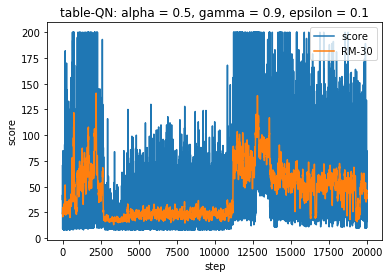

In [5]:
w = 15
plt.plot(last_reward)
plt.plot([last_reward[max(0, i-w):min(len(last_reward), i+w)].mean() for i in range(len(last_reward))])
plt.legend(['score', 'RM-{}'.format(2*w)])
plt.title('table-QN: alpha = {}, gamma = {}, epsilon = {}'.format(alpha, gamma, epsilon))
plt.xlabel('step')
plt.ylabel('score')
plt.show()

# Deep Q-learning


Если количество состояний велико, даже бесконечно ($~R^4$), то все запомнить не получится.

Приходится использовать апроксимацию Q-функции.

Например аппроксимацию нейронной сетью, т.е. $Q(s,a) = Q_{nn}(s,a|\theta)$, где $\theta$-веса сетки

<img src="https://pp.userapi.com/c840129/v840129239/4afe4/R9TwZiy1LoA.jpg" alt="MDP" style="width: 600px;"/>

Есть только история $(s, a, r, s')$, полученная при следовании данной политике.

Получим N таких значений и пересчитаем параметры $\theta$, т.е. веса нейронной сети:

$$Q_{target}(s,a) = r + gamma\cdot \max_{a'} Q(s',a' | \theta)$$
$$Loss(\theta) = \frac{1}{N} \sum_{(s,a,r,s') \in batch} \left[Q_target(s,a) - Q(s,a | \theta)\right]^2$$



In [6]:
import gym
import random
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2

Using TensorFlow backend.


In [7]:
class DeepQ:
    def __init__(self, inputs, outputs, mem_size, gamma, learning_rate, epsilon, batch_size):
        """
        Параметры:
            - inputs: размерность входного вектора
            - outputs: размерность выходного вектора (к-во действий)
            - mem_size: размер буфера памяти
            - gamma: параметр затухания награды
            - learning_rate: множитель перед градиентом в SGD
            - batch_size: размер подвыборки для тренировки
        """
        self.actions = range(outputs)
        self.epsilon = epsilon
        self.input_size = inputs
        self.output_size = outputs
        self.memory = []
        self.mem_size = mem_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.global_i = 0
        self.model = self.create_model()
        
    def create_model(self):
        model = Sequential()
        hiddenLayers = [30,30]
#         hiddenLayers = [30]
        activationType = 'relu'
        model.add(Dense(hiddenLayers[0], input_shape=(self.input_size,), init='lecun_uniform'))
        model.add(Activation(activationType))

        for index in range(1, len(hiddenLayers)):
            model.add(Dense(hiddenLayers[index], init='lecun_uniform'))
            model.add(Activation(activationType))

#       На выходе числа из R
        model.add(Dense(self.output_size, init='lecun_uniform'))
        model.add(Activation("linear"))
        
#       Оптимизатор, чтобы устремлять Q -> Q_target
        optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-06)
    
#       Ф-я потерь sum((Q[:]-Q_target[:])**2)
        model.compile(loss="mse", optimizer=optimizer)
        model.summary()
        return model

    def get_Q_values(self, state):
        predicted = self.model.predict(state.reshape(1,-1))
        return predicted[0]
    
    def chooseAction(self, state):
        q = self.get_Q_values(state).tolist()
        maxQ = max(q)
        
        # Отвечает за баланс исследование-использование (exploration vs expluatation)
        # С вероятностью epsilon случайное действие, 1-epsilon - argmax(Q)
        if random.random() < self.epsilon:
            minQ = min(q); mag = max(abs(minQ), abs(maxQ))
            q = [q[i] + random.random() * mag - .5 * mag for i in range(len(self.actions))]
            maxQ = max(q)

        count = q.count(maxQ)
        
        # Если максимум Q достигается для двух и более действий - берем любое
        if count > 1:
            best = [i for i in range(len(self.actions)) if q[i] == maxQ]
            action = random.choice(best)
        else:
            action = q.index(maxQ)
        return action
    
        # Пересчет значения Q(s,a) := r + gamma * max Q(s',a')
    def calc_target(self, Q_values, reward, is_done):
        if is_done:
            return reward
        else : 
            return reward + self.gamma * max(Q_values)
    
    def remember(self, sarsd):
        if len(self.memory) < self.mem_size:
            self.memory.append(sarsd)
        else:
            self.memory[self.global_i%self.mem_size] = sarsd
        self.global_i += 1
        
    def learn(self):
        #выберем случайную подвыборку длины self.batch_size
        batch_indexes = random.sample(range(len(self.memory)), self.batch_size)
        
        #контейнеры  X = вход; Y = ответ
        X_batch = np.zeros((self.batch_size, self.input_size))
        Y_batch = np.zeros((self.batch_size, self.output_size))
        j = 0

        for i in batch_indexes:
        # выбираем из памяти s_t, a_t, r_t, s_{t+1} и метку конца 
            state, action, reward, new_state, is_done = self.memory[i]

            # Q_target(s,a) := r + gamma * max Q(s',a')
            Q_values = self.get_Q_values(state)
            Q_values_new = self.get_Q_values(new_state)
            Q_target = self.calc_target(Q_values_new, reward, is_done)

            # Для всех a, кроме a_t не трогаем, для a_t меняем
            X_batch[j] = np.array([state.copy()])
            Y_sample = Q_values.copy()
            Y_sample[action] = Q_target
            Y_batch[j] = np.array([Y_sample])
            
            
            if is_done:
                X_batch[j] = np.array([new_state.copy()])
                Y_batch[j] = np.array([[reward]*self.output_size])
            j += 1
            
#       Оптимизатор устремляет Q -> Q_target
#       т.е. делает 1 шаг против направления градиента ф-и потерь L = sum((Q[:]-Q_target[:])**2) по параметрам сетки
        self.model.fit(X_batch, Y_batch, batch_size = self.batch_size, nb_epoch=1, verbose = 0)

In [11]:
# env = gym.make('MsPacman-v0')
env = gym.make('CartPole-v1')
goal_average_steps = 475
goal_number_of_steps = 500

# env = gym.wrappers.Monitor(env, '/tmp/cartpole-experiment-1', force=True)

mem_size = 1024
gamma = 0.99
learning_rate = 0.00525
epsilon = 0.1

batch_size  = 256
learn_step = 256
last_reward = np.ndarray(0)
state = env.reset().ravel()
# Инициализация глубокого Q-learning
qlearn = DeepQ(state.shape[0], env.action_space.n, mem_size, gamma, learning_rate, epsilon, batch_size)

for i_episode in xrange(3000):
    state = env.reset().ravel()
    cum_reward = 0
    for t in xrange(goal_number_of_steps):
#         можно смотреть, как агент учится
        if i_episode % 100 == 0: 
            env.render()

        # в соответствии с политикой выберем действие
        action = qlearn.chooseAction(state)
        
        # получим новое наблюдение, награду, метку конца эпизода
        new_state, reward, is_done, info = env.step(action)
        new_state = new_state.ravel()
        cum_reward += reward
        if not(is_done):
            qlearn.remember((state, action, reward, new_state, is_done))
            state = new_state
        else:
        # штраф за поражение
            reward = -200
            qlearn.remember((state, action, reward, new_state, is_done))
            last_reward = np.append(last_reward, cum_reward)
            break
            
    if qlearn.global_i > learn_step:
#         print(qlearn.global_i)
        qlearn.learn()
    print("episode: {}, score: {}, 30-mean: {:0.1f}".format(i_episode, t, last_reward[-30:].mean()))
    if (last_reward[-100:].mean() > goal_average_steps):
        print ("Win!")
        break

env.close()
# gym.upload('/tmp/cartpole-experiment-1', algorithm_id='vmayoral simple Q-learning', api_key='your-key')

[2017-10-05 17:57:44,585] Making new env: CartPole-v1
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(30, kernel_initializer="lecun_uniform", input_shape=(4,))`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(30, kernel_initializer="lecun_uniform")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, kernel_initializer="lecun_uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                150       
_________________________________________________________________
activation_4 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
_________________________________________________________________
activation_5 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 62        
_________________________________________________________________
activation_6 (Activation)    (None, 2)                 0         
Total params: 1,142
Trainable params: 1,142
Non-trainable params: 0
_________________________________________________________________
episode:

episode: 191, score: 61, 30-mean: 61.6
episode: 192, score: 39, 30-mean: 61.8
episode: 193, score: 37, 30-mean: 61.5
episode: 194, score: 39, 30-mean: 60.2
episode: 195, score: 61, 30-mean: 61.0
episode: 196, score: 32, 30-mean: 60.7
episode: 197, score: 27, 30-mean: 60.7
episode: 198, score: 43, 30-mean: 56.0
episode: 199, score: 68, 30-mean: 56.1
episode: 200, score: 29, 30-mean: 55.7
episode: 201, score: 59, 30-mean: 56.0
episode: 202, score: 53, 30-mean: 56.7
episode: 203, score: 36, 30-mean: 54.6
episode: 204, score: 107, 30-mean: 56.4
episode: 205, score: 54, 30-mean: 57.3
episode: 206, score: 46, 30-mean: 56.4
episode: 207, score: 35, 30-mean: 56.7
episode: 208, score: 35, 30-mean: 56.2
episode: 209, score: 37, 30-mean: 56.4
episode: 210, score: 35, 30-mean: 56.3
episode: 211, score: 31, 30-mean: 55.9
episode: 212, score: 56, 30-mean: 56.4
episode: 213, score: 51, 30-mean: 57.0
episode: 214, score: 53, 30-mean: 54.5
episode: 215, score: 33, 30-mean: 54.4
episode: 216, score: 41,

episode: 402, score: 44, 30-mean: 49.5
episode: 403, score: 38, 30-mean: 49.9
episode: 404, score: 66, 30-mean: 50.8
episode: 405, score: 27, 30-mean: 50.5
episode: 406, score: 57, 30-mean: 50.9
episode: 407, score: 116, 30-mean: 53.6
episode: 408, score: 55, 30-mean: 53.3
episode: 409, score: 31, 30-mean: 52.9
episode: 410, score: 70, 30-mean: 54.1
episode: 411, score: 36, 30-mean: 52.9
episode: 412, score: 89, 30-mean: 54.3
episode: 413, score: 48, 30-mean: 53.7
episode: 414, score: 61, 30-mean: 54.6
episode: 415, score: 99, 30-mean: 56.7
episode: 416, score: 39, 30-mean: 57.1
episode: 417, score: 45, 30-mean: 56.1
episode: 418, score: 29, 30-mean: 55.8
episode: 419, score: 26, 30-mean: 55.6
episode: 420, score: 48, 30-mean: 55.5
episode: 421, score: 52, 30-mean: 55.4
episode: 422, score: 54, 30-mean: 55.7
episode: 423, score: 59, 30-mean: 56.1
episode: 424, score: 32, 30-mean: 56.0
episode: 425, score: 67, 30-mean: 56.9
episode: 426, score: 59, 30-mean: 56.2
episode: 427, score: 57,

episode: 608, score: 374, 30-mean: 242.0
episode: 609, score: 361, 30-mean: 244.0
episode: 610, score: 499, 30-mean: 244.0
episode: 611, score: 431, 30-mean: 248.1
episode: 612, score: 499, 30-mean: 256.0
episode: 613, score: 499, 30-mean: 262.4
episode: 614, score: 301, 30-mean: 271.1
episode: 615, score: 302, 30-mean: 272.1
episode: 616, score: 499, 30-mean: 287.4
episode: 617, score: 499, 30-mean: 297.8
episode: 618, score: 499, 30-mean: 312.6
episode: 619, score: 499, 30-mean: 322.3
episode: 620, score: 499, 30-mean: 331.9
episode: 621, score: 499, 30-mean: 346.8
episode: 622, score: 499, 30-mean: 362.0
episode: 623, score: 499, 30-mean: 371.5
episode: 624, score: 499, 30-mean: 380.6
episode: 625, score: 499, 30-mean: 391.2
episode: 626, score: 499, 30-mean: 399.3
episode: 627, score: 499, 30-mean: 402.6
episode: 628, score: 499, 30-mean: 411.4
episode: 629, score: 499, 30-mean: 420.5
episode: 630, score: 499, 30-mean: 430.0
episode: 631, score: 499, 30-mean: 432.1
episode: 632, sc

episode: 808, score: 499, 30-mean: 500.0
episode: 809, score: 499, 30-mean: 500.0
episode: 810, score: 499, 30-mean: 500.0
episode: 811, score: 499, 30-mean: 500.0
episode: 812, score: 499, 30-mean: 500.0
episode: 813, score: 499, 30-mean: 500.0
episode: 814, score: 499, 30-mean: 500.0
episode: 815, score: 499, 30-mean: 500.0
episode: 816, score: 499, 30-mean: 500.0
episode: 817, score: 499, 30-mean: 500.0
episode: 818, score: 499, 30-mean: 500.0
episode: 819, score: 499, 30-mean: 500.0
episode: 820, score: 499, 30-mean: 500.0
episode: 821, score: 499, 30-mean: 500.0
episode: 822, score: 499, 30-mean: 500.0
episode: 823, score: 499, 30-mean: 500.0
episode: 824, score: 499, 30-mean: 500.0
episode: 825, score: 499, 30-mean: 500.0
episode: 826, score: 499, 30-mean: 500.0
episode: 827, score: 499, 30-mean: 500.0
episode: 828, score: 499, 30-mean: 500.0
episode: 829, score: 499, 30-mean: 500.0
episode: 830, score: 499, 30-mean: 500.0
episode: 831, score: 499, 30-mean: 500.0
episode: 832, sc

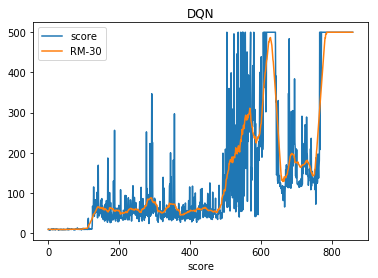

In [12]:
w = 15
plt.plot(last_reward)
plt.plot([last_reward[max(0, i-w):min(len(last_reward), i+w)].mean() for i in range(len(last_reward))])
plt.legend(['score', 'RM-{}'.format(2*w)])
plt.title('DQN')
plt.xlabel('step')
plt.xlabel('score')
plt.show()

## Домашнее задание

0. Проследить зависимость результата от epsilon, построить графики для epsilon = [0.01, 0.07, 0.2, 0.5];
0. Проследить зависимость результата от learning_rate, построить графики для разных learning_rate;
0. Динамически менять epsilon и learning_rate, обучиться быстрее и стабильнее
0. Усложнить модель, добавить слои, поменять число нейронов, ф-ию активации;
0. $^*$ Набрать 1000 очков в [Ms.Packman](https://gym.openai.com/envs/MsPacman-v0/) в OpenAI.gym. Скорее всего понадобится добавить пару сверточных слоев

За иллюстрации отдельное спасибо А.Гринчуку, см. [его семинар](rl_advantages.pdf)